In [ ]:
!pip install lightning
!pip install git+https://github.com/stefanonardo/pytorch-esn.git@master

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 17.3 MB/s eta 0:00:00
  Cloning https://github.com/stefanonardo/pytorch-esn.git (to revision master) to /tmp/pip-req-build-30gxghkv
  Running command git clone --filter=blob:none --quiet https://github.com/stefanonardo/pytorch-esn.git /tmp/pip-req-build-30gxghkv
  Resolved https://github.com/stefanonardo/pytorch-esn.git to commit 27397b6ebd34bfd3cd20c827f6bf8e5ff7ba9f26
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-esn: filename=pytorch_esn-1.2.4-py3-none-any.whl size=10074 sha256=1095666af6f9ce8192ca35cf601ec56ba106b0120483e8623fbfadb2f21f4fe5
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzjgfbnx/wheels/53/9e/12/67d07036e14b14baeaddd9792cc0d2e66236efa2f939384f01
Successfully built pytorch-esn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
base_dir: str = "drive/MyDrive/ColabNotebooks/commonfolder/flf-lstm"

In [ ]:
import os
from typing import Tuple, List, Optional, Callable, Any, Dict
import torch
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import seed_everything

In [ ]:
seed: int = 42
seed_everything(seed)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [ ]:
def mse(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return ((predictions - targets) ** 2).mean()

def readDataset(filename: str) -> np.ndarray:
    text_file = open(filename, 'r')
    dataset = []
    for line in text_file:
        line = line.split(',')
        dt = [float(x) for x in line ]
        dataset.append(dt)
    text_file.close()
    dataset = np.array(dataset)
    return dataset

def tagData(data: np.ndarray, perc: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sz = math.ceil(data.shape[0] * perc / 100)
    dat = np.zeros((data.shape[0], data.shape[1] * 2))
    dat[:data.shape[0], :data.shape[1]] = data
    dat[:data.shape[0]-1, data.shape[1]:] = data[1:,:]
    xtrain = dat[:sz, :4]
    ytrain = dat[:sz, 4:]
    xtest = dat[sz-1:, :4]
    ytest = dat[sz-1:, 4:]
    xtrain = torch.tensor(xtrain, dtype=torch.float32).unsqueeze(1)
    ytrain = torch.tensor(ytrain, dtype=torch.float32).unsqueeze(1)
    xtest = torch.tensor(xtest, dtype=torch.float32).unsqueeze(1)
    ytest = torch.tensor(ytest, dtype=torch.float32).unsqueeze(1)
    return xtrain, ytrain, xtest, ytest

file = base_dir + '/Data/EURUSDmicro_H4_CandleData.txt'
percentage_train: float = 60

data = readDataset(file)
xtrain, ytrain, xtest, ytest = tagData(data, percentage_train)
print('training samples: ', xtrain.shape)
print('testing samples: ', xtest.shape)
print('training samples: ', ytrain.shape)
print('testing samples: ', ytest.shape)

training samples:  torch.Size([6047, 1, 4])
testing samples:  torch.Size([4031, 1, 4])
training samples:  torch.Size([6047, 1, 4])
testing samples:  torch.Size([4031, 1, 4])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
percentage_val: float = 10

# define the custom dataset class for Forex data
class ForexDataset(torch.utils.data.Dataset):
    def __init__(self, x_data: torch.Tensor, y_data: torch.Tensor):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.x_data[idx] if len(self.x_data[idx].shape) >= 2 else self.x_data[idx].unsqueeze(1)
        y = self.y_data[idx] if len(self.y_data[idx].shape) >= 2 else self.y_data[idx].unsqueeze(1)
        return x, y


ds = ForexDataset(xtrain, ytrain)
len_val = int((percentage_val / 100) * len(ds))
len_train = len(ds) - len_val
train_dataset, val_dataset = torch.utils.data.random_split(ds, [len_train, len_val])
test_dataset = ForexDataset(xtest, ytest)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 5443, Val: 604, Test: 4031


In [ ]:
def flf_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    lam = 0.1
    v = (y_true - y_pred) * 0.9
    vn = lam * torch.abs((y_true[..., 1] + y_true[..., 2]) / 2 - (y_pred[..., 1] + y_pred[..., 2]) / 2)
    vn1 = lam * torch.abs((y_true[..., 0] + y_true[..., 3]) / 2 - (y_pred[..., 0] + y_pred[..., 3]) / 2)
    vx = (v[..., 0] - vn1) ** 2
    vy = (v[..., 1] - vn) ** 2
    vz = (v[..., 2] - vn) ** 2
    v4 = (v[..., 3] - vn1) ** 2
    vm = torch.cat([vx, vy, vz, v4])
    vmx = vm.mean()
    return vmx

In [ ]:
input_dim: int = 4
hidden_dim: int = 250
output_dim: int = 4
batch_size: int = 72
num_epochs: int = 150
early_stopping_patience: int = 10
learning_rate: float = 0.00001
beta_1: float = 0.09
beta_2: float = 0.0999
epsilon: float = 1e-8
schedule_decay: float = 0.0004
activations: list[str] = ["Tanh", "Sigmoid", "ReLU", "GELU", "ELU", "SiLU"]

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

a, b = next(iter(train_loader))
print(a.shape)
print(b.shape)

torch.Size([72, 1, 4])
torch.Size([72, 1, 4])


In [ ]:
class FLFModel(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation_fn: nn.Module,
                 recurrent_net_type: str = "lstm"):
        super(FLFModel, self).__init__()

        # Store attributes
        self._input_size: int = input_size
        self._hidden_size: int = hidden_size
        self._output_size: int = output_size
        self._activation_fn: nn.Module = activation_fn

        # Initialize layers
        self._rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self._fc = nn.Linear(hidden_size, output_size)

    @property
    def input_size(self) -> int:
      return self._inputs_size

    @property
    def hidden_size(self) -> int:
      return self._hidden_size

    @property
    def output_size(self) -> int:
      return self._output_size

    @property
    def activation_fn(self) -> nn.Module:
      return self._activation_fn

    @property
    def rnn(self) -> torch.nn.Module:
      return self._rnn

    @property
    def fc(self) -> nn.Linear:
      return self._fc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.rnn(x)
        out = self.activation_fn(out)
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

In [ ]:
def evaluate_model(model: nn.Module,
                   criterion: Callable[..., torch.Tensor],
                   data_loader: torch.utils.data.DataLoader,
                   **kw_additional_metrics) -> Tuple[float, Dict[str, float]]:
    model.eval()  # put the model in evaluation mode
    test_loss = 0.0
    additional_metrics = {k: 0.0 for k in kw_additional_metrics}

    with torch.no_grad():
        for inputs, targets in tqdm(iter(data_loader), desc="Validation step..."):

            # Put the batch on device
            inputs, targets = inputs.to(device), targets.to(device)

            # Get model outputs
            outputs = model(inputs)
            outputs = outputs.unsqueeze(1) if len(outputs.shape) <= 2 else outputs

            # Compute the loss
            loss = criterion(outputs, targets)

            # Compute additional metrics
            for k in additional_metrics:
              metric = kw_additional_metrics[k]
              additional_metrics[k] += float(metric(outputs, targets)) * inputs.size(0)
            test_loss += loss.item() * inputs.size(0)

    # Average the loss/metrics
    test_loss /= len(data_loader.dataset)
    for k in additional_metrics:
      additional_metrics[k] = additional_metrics[k] / len(data_loader.dataset)

    return test_loss, additional_metrics

def train_model(model: nn.Module,
                criterion: Callable[..., torch.Tensor],
                optimizer,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                epochs: int = 150,
                patience: int = 10,
                **kw_additional_metrics) -> Tuple[nn.Module, List[float], List[float]]:
    train_losses = []
    val_losses = []
    model = model.to(device)
    early_stop_counter = 0
    best_val_loss = 9999999.0
    best_weights = None

    # For each epoch
    for epoch in range(epochs):
        model.train()  # put the model in train mode
        train_loss = 0.0

        # Train Step
        for inputs, targets in tqdm(iter(train_loader), desc="Train step..."):

            # Put the batch on device
            inputs, targets = inputs.to(device), targets.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Get model outputs
            outputs = model(inputs)
            outputs = outputs.unsqueeze(1) if len(outputs.shape) <= 2 else outputs

            # Compute the loss/gradients and do optimizer step
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)  # average the loss

        # Validation step
        val_loss, additional_metrics = evaluate_model(model, criterion, val_loader, **kw_additional_metrics)

        # Handle loss history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},"
              f"\n Additional metrics: {additional_metrics}")

        # Early stopping handling
        if val_loss < best_val_loss:
          print(f"Epoch {epoch + 1}/{epochs}, Found better validation loss {val_loss} < {best_val_loss}.")
          best_val_loss = val_loss
          best_weights = model.state_dict()
          early_stop_counter = 0
        else:
          early_stop_counter += 1
          print(f"Epoch {epoch + 1}/{epochs}, loss didn't improve. Early stop counter increased to {early_stop_counter}/{patience}.")
          if early_stop_counter >= patience:
            print(f"Epoch {epoch + 1}/{epochs}, early stopping.\n")
            break

    # Load the best state dict
    model.load_state_dict(best_weights)

    return model, train_losses, val_losses

In [ ]:
# Train the model with every activation
models = {}
history_val = {}
history_train = {}
test_losses = {}
test_mses = {}

for act in activations:

    # Get the activation function
    activation_func = getattr(nn, act)()

    # Instantiate the model and the loss
    model = FLFModel(input_size=xtrain.shape[2], hidden_size=hidden_dim, output_size=output_dim, activation_fn=activation_func)  # You can change hidden_size as needed
    criterion = flf_loss

    # Define the optimizer
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon)

    # Train the model and store it
    model, train_losses_, val_losses_ = train_model(model, criterion, optimizer, train_loader, test_loader, epochs=num_epochs, patience=early_stopping_patience, mse=torch.nn.MSELoss())
    models[act] = model

    # Evaluate the model on the test set
    test_loss, additional_metrics = evaluate_model(model, criterion, test_loader, mse=torch.nn.MSELoss())

    # Store the loss history and the other metrics
    history_val[act] = val_losses_
    history_train[act] = train_losses_
    test_losses[act] = test_loss
    test_mses[act] = additional_metrics["mse"]
    print(f"Test Loss for {act}: {test_loss:.4f}, Additional metrics: {additional_metrics}\n\n")

Validation step...: 100%|██████████| 56/56 [00:00<00:00, 388.26it/s]


Epoch 1/150, Train Loss: 1.6916, Val Loss: 1.3921,
 Additional metrics: {'mse': 1.3922276982478012}
Epoch 1/150, Found better validation loss 1.3921326330239825 < 9999999.0.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 524.99it/s]


Epoch 2/150, Train Loss: 1.6647, Val Loss: 1.3693,
 Additional metrics: {'mse': 1.3694013675960823}
Epoch 2/150, Found better validation loss 1.3693057850494896 < 1.3921326330239825.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 538.67it/s]


Epoch 3/150, Train Loss: 1.6380, Val Loss: 1.3466,
 Additional metrics: {'mse': 1.3466649906891388}
Epoch 3/150, Found better validation loss 1.3465691527194168 < 1.3693057850494896.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 544.20it/s]


Epoch 4/150, Train Loss: 1.6113, Val Loss: 1.3238,
 Additional metrics: {'mse': 1.3239107792030282}
Epoch 4/150, Found better validation loss 1.3238150626014344 < 1.3465691527194168.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 524.71it/s]


Epoch 5/150, Train Loss: 1.5846, Val Loss: 1.3010,
 Additional metrics: {'mse': 1.3010536372824242}
Epoch 5/150, Found better validation loss 1.3009574928759227 < 1.3238150626014344.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 502.81it/s]


Epoch 6/150, Train Loss: 1.5576, Val Loss: 1.2779,
 Additional metrics: {'mse': 1.278009450308474}
Epoch 6/150, Found better validation loss 1.2779123205844063 < 1.3009574928759227.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 527.20it/s]


Epoch 7/150, Train Loss: 1.5303, Val Loss: 1.2546,
 Additional metrics: {'mse': 1.2547079616017627}
Epoch 7/150, Found better validation loss 1.2546091804549346 < 1.2779123205844063.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.33it/s]


Epoch 8/150, Train Loss: 1.5028, Val Loss: 1.2310,
 Additional metrics: {'mse': 1.2310801978384522}
Epoch 8/150, Found better validation loss 1.2309799422640506 < 1.2546091804549346.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.21it/s]


Epoch 9/150, Train Loss: 1.4748, Val Loss: 1.2070,
 Additional metrics: {'mse': 1.2070694135040363}
Epoch 9/150, Found better validation loss 1.2069682862616093 < 1.2309799422640506.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 544.21it/s]


Epoch 10/150, Train Loss: 1.4464, Val Loss: 1.1825,
 Additional metrics: {'mse': 1.1826275978630159}
Epoch 10/150, Found better validation loss 1.1825259409953925 < 1.2069682862616093.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 359.50it/s]


Epoch 11/150, Train Loss: 1.4173, Val Loss: 1.1576,
 Additional metrics: {'mse': 1.1577088247898701}
Epoch 11/150, Found better validation loss 1.1576056987291174 < 1.1825259409953925.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 345.24it/s]


Epoch 12/150, Train Loss: 1.3877, Val Loss: 1.1322,
 Additional metrics: {'mse': 1.132295821831499}
Epoch 12/150, Found better validation loss 1.1321910450873143 < 1.1576056987291174.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 366.41it/s]


Epoch 13/150, Train Loss: 1.3575, Val Loss: 1.1063,
 Additional metrics: {'mse': 1.1063740116820622}
Epoch 13/150, Found better validation loss 1.106268056212037 < 1.1321910450873143.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 352.74it/s]


Epoch 14/150, Train Loss: 1.3266, Val Loss: 1.0798,
 Additional metrics: {'mse': 1.0799188935351531}
Epoch 14/150, Found better validation loss 1.079812338824782 < 1.106268056212037.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 365.21it/s]


Epoch 15/150, Train Loss: 1.2951, Val Loss: 1.0528,
 Additional metrics: {'mse': 1.0529151788511397}
Epoch 15/150, Found better validation loss 1.0528077422995865 < 1.079812338824782.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 513.78it/s]


Epoch 16/150, Train Loss: 1.2629, Val Loss: 1.0252,
 Additional metrics: {'mse': 1.0253520132264498}
Epoch 16/150, Found better validation loss 1.025243343179618 < 1.0528077422995865.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.39it/s]


Epoch 17/150, Train Loss: 1.2300, Val Loss: 0.9971,
 Additional metrics: {'mse': 0.997218963349318}
Epoch 17/150, Found better validation loss 0.9971092871358631 < 1.025243343179618.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 427.12it/s]


Epoch 18/150, Train Loss: 1.1964, Val Loss: 0.9684,
 Additional metrics: {'mse': 0.9685158162340577}
Epoch 18/150, Found better validation loss 0.9684050324329281 < 0.9971092871358631.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 559.04it/s]


Epoch 19/150, Train Loss: 1.1621, Val Loss: 0.9391,
 Additional metrics: {'mse': 0.9392504544951312}
Epoch 19/150, Found better validation loss 0.9391376793281047 < 0.9684050324329281.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 540.37it/s]


Epoch 20/150, Train Loss: 1.1271, Val Loss: 0.9093,
 Additional metrics: {'mse': 0.9094505229028216}
Epoch 20/150, Found better validation loss 0.9093354889844375 < 0.9391376793281047.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 523.13it/s]


Epoch 21/150, Train Loss: 1.0915, Val Loss: 0.8790,
 Additional metrics: {'mse': 0.879139523460622}
Epoch 21/150, Found better validation loss 0.8790220177904071 < 0.9093354889844375.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 550.18it/s]


Epoch 22/150, Train Loss: 1.0553, Val Loss: 0.8482,
 Additional metrics: {'mse': 0.8483417350729533}
Epoch 22/150, Found better validation loss 0.8482213882085733 < 0.8790220177904071.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 544.61it/s]


Epoch 23/150, Train Loss: 1.0184, Val Loss: 0.8170,
 Additional metrics: {'mse': 0.817092990600214}
Epoch 23/150, Found better validation loss 0.8169695332487414 < 0.8482213882085733.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 546.35it/s]


Epoch 24/150, Train Loss: 0.9810, Val Loss: 0.7853,
 Additional metrics: {'mse': 0.7854438205564978}
Epoch 24/150, Found better validation loss 0.7853171697653011 < 0.8169695332487414.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 521.60it/s]


Epoch 25/150, Train Loss: 0.9432, Val Loss: 0.7533,
 Additional metrics: {'mse': 0.753442047710485}
Epoch 25/150, Found better validation loss 0.753312238730736 < 0.7853171697653011.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 521.22it/s]


Epoch 26/150, Train Loss: 0.9049, Val Loss: 0.7210,
 Additional metrics: {'mse': 0.7211314566494424}
Epoch 26/150, Found better validation loss 0.7209981874507582 < 0.753312238730736.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.09it/s]


Epoch 27/150, Train Loss: 0.8663, Val Loss: 0.6884,
 Additional metrics: {'mse': 0.6885728658768652}
Epoch 27/150, Found better validation loss 0.6884358440844897 < 0.7209981874507582.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 508.50it/s]


Epoch 28/150, Train Loss: 0.8274, Val Loss: 0.6557,
 Additional metrics: {'mse': 0.6558151656775166}
Epoch 28/150, Found better validation loss 0.6556738084494047 < 0.6884358440844897.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.70it/s]


Epoch 29/150, Train Loss: 0.7882, Val Loss: 0.6228,
 Additional metrics: {'mse': 0.6229144191363407}
Epoch 29/150, Found better validation loss 0.6227684044654598 < 0.6556738084494047.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 562.48it/s]


Epoch 30/150, Train Loss: 0.7488, Val Loss: 0.5898,
 Additional metrics: {'mse': 0.5899317640135644}
Epoch 30/150, Found better validation loss 0.5897808844296165 < 0.6227684044654598.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 576.39it/s]


Epoch 31/150, Train Loss: 0.7093, Val Loss: 0.5568,
 Additional metrics: {'mse': 0.5569262567272674}
Epoch 31/150, Found better validation loss 0.5567701638883469 < 0.5897808844296165.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 540.55it/s]


Epoch 32/150, Train Loss: 0.6698, Val Loss: 0.5238,
 Additional metrics: {'mse': 0.5239659944381467}
Epoch 32/150, Found better validation loss 0.5238041527304984 < 0.5567701638883469.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 564.30it/s]


Epoch 33/150, Train Loss: 0.6303, Val Loss: 0.4910,
 Additional metrics: {'mse': 0.49112892548637516}
Epoch 33/150, Found better validation loss 0.4909610213904545 < 0.5238041527304984.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 559.39it/s]


Epoch 34/150, Train Loss: 0.5910, Val Loss: 0.4583,
 Additional metrics: {'mse': 0.45849257890949235}
Epoch 34/150, Found better validation loss 0.4583188215664793 < 0.4909610213904545.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.87it/s]


Epoch 35/150, Train Loss: 0.5519, Val Loss: 0.4260,
 Additional metrics: {'mse': 0.4261379774703308}
Epoch 35/150, Found better validation loss 0.42595799238827886 < 0.4583188215664793.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 527.70it/s]


Epoch 36/150, Train Loss: 0.5131, Val Loss: 0.3940,
 Additional metrics: {'mse': 0.39415482383778655}
Epoch 36/150, Found better validation loss 0.3939682350460929 < 0.42595799238827886.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 367.24it/s]


Epoch 37/150, Train Loss: 0.4748, Val Loss: 0.3624,
 Additional metrics: {'mse': 0.36263132449475155}
Epoch 37/150, Found better validation loss 0.36243774446711235 < 0.3939682350460929.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 367.69it/s]


Epoch 38/150, Train Loss: 0.4370, Val Loss: 0.3315,
 Additional metrics: {'mse': 0.3316634032987123}
Epoch 38/150, Found better validation loss 0.33146242441388163 < 0.36243774446711235.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 333.99it/s]


Epoch 39/150, Train Loss: 0.3999, Val Loss: 0.3011,
 Additional metrics: {'mse': 0.3013518921230603}
Epoch 39/150, Found better validation loss 0.3011430999875453 < 0.33146242441388163.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 344.95it/s]


Epoch 40/150, Train Loss: 0.3636, Val Loss: 0.2716,
 Additional metrics: {'mse': 0.2718021907586964}
Epoch 40/150, Found better validation loss 0.2715851434612061 < 0.3011430999875453.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 362.74it/s]


Epoch 41/150, Train Loss: 0.3282, Val Loss: 0.2429,
 Additional metrics: {'mse': 0.24312585904266426}
Epoch 41/150, Found better validation loss 0.2429001172225903 < 0.2715851434612061.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.59it/s]


Epoch 42/150, Train Loss: 0.2938, Val Loss: 0.2152,
 Additional metrics: {'mse': 0.21543514645741377}
Epoch 42/150, Found better validation loss 0.21520025865134398 < 0.2429001172225903.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 538.69it/s]


Epoch 43/150, Train Loss: 0.2605, Val Loss: 0.1886,
 Additional metrics: {'mse': 0.188846629367103}
Epoch 43/150, Found better validation loss 0.18860212540292348 < 0.21520025865134398.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 568.80it/s]


Epoch 44/150, Train Loss: 0.2286, Val Loss: 0.1632,
 Additional metrics: {'mse': 0.16347707386230956}
Epoch 44/150, Found better validation loss 0.16322246777215804 < 0.18860212540292348.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 438.41it/s]


Epoch 45/150, Train Loss: 0.1982, Val Loss: 0.1392,
 Additional metrics: {'mse': 0.13945727236245473}
Epoch 45/150, Found better validation loss 0.13919207182024584 < 0.16322246777215804.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 529.86it/s]


Epoch 46/150, Train Loss: 0.1693, Val Loss: 0.1166,
 Additional metrics: {'mse': 0.11691701808850542}
Epoch 46/150, Found better validation loss 0.11664070499517047 < 0.13919207182024584.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 531.39it/s]


Epoch 47/150, Train Loss: 0.1421, Val Loss: 0.0957,
 Additional metrics: {'mse': 0.0959851831545223}
Epoch 47/150, Found better validation loss 0.09569722857059187 < 0.11664070499517047.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 546.73it/s]


Epoch 48/150, Train Loss: 0.1169, Val Loss: 0.0765,
 Additional metrics: {'mse': 0.07680150234013153}
Epoch 48/150, Found better validation loss 0.07650136392211476 < 0.09569722857059187.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 501.01it/s]


Epoch 49/150, Train Loss: 0.0938, Val Loss: 0.0592,
 Additional metrics: {'mse': 0.05950387178395055}
Epoch 49/150, Found better validation loss 0.059190987307819534 < 0.07650136392211476.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 559.53it/s]


Epoch 50/150, Train Loss: 0.0729, Val Loss: 0.0439,
 Additional metrics: {'mse': 0.04423953099275635}
Epoch 50/150, Found better validation loss 0.04391332594407489 < 0.059190987307819534.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.19it/s]


Epoch 51/150, Train Loss: 0.0544, Val Loss: 0.0308,
 Additional metrics: {'mse': 0.031156523794091034}
Epoch 51/150, Found better validation loss 0.03081640517151968 < 0.04391332594407489.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 528.72it/s]


Epoch 52/150, Train Loss: 0.0385, Val Loss: 0.0201,
 Additional metrics: {'mse': 0.020407732663002894}
Epoch 52/150, Found better validation loss 0.020053097041135715 < 0.03081640517151968.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 533.34it/s]


Epoch 53/150, Train Loss: 0.0254, Val Loss: 0.0118,
 Additional metrics: {'mse': 0.012151329012236948}
Epoch 53/150, Found better validation loss 0.011781566007202803 < 0.020053097041135715.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 459.53it/s]


Epoch 54/150, Train Loss: 0.0152, Val Loss: 0.0062,
 Additional metrics: {'mse': 0.00654613467626952}
Epoch 54/150, Found better validation loss 0.0061606340539112365 < 0.011781566007202803.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 559.45it/s]


Epoch 55/150, Train Loss: 0.0081, Val Loss: 0.0030,
 Additional metrics: {'mse': 0.0034069774537923703}
Epoch 55/150, Found better validation loss 0.0030020353830454366 < 0.0061606340539112365.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 544.82it/s]


Epoch 56/150, Train Loss: 0.0038, Val Loss: 0.0016,
 Additional metrics: {'mse': 0.002151750010574346}
Epoch 56/150, Found better validation loss 0.00163919407794868 < 0.0030020353830454366.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 569.69it/s]


Epoch 57/150, Train Loss: 0.0016, Val Loss: 0.0010,
 Additional metrics: {'mse': 0.0014213394668000385}
Epoch 57/150, Found better validation loss 0.0009909525284457225 < 0.00163919407794868.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 548.58it/s]


Epoch 58/150, Train Loss: 0.0006, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011723603621589382}
Epoch 58/150, Found better validation loss 0.0007578008338751022 < 0.0009909525284457225.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 515.30it/s]


Epoch 59/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012058122868070214}
Epoch 59/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 548.10it/s]


Epoch 60/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011505007952233605}
Epoch 60/150, Found better validation loss 0.0007368833928617815 < 0.0007578008338751022.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 522.15it/s]


Epoch 61/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010967388335069912}
Epoch 61/150, Found better validation loss 0.0007024841289874883 < 0.0007368833928617815.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 519.45it/s]


Epoch 62/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001159488108420698}
Epoch 62/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 366.42it/s]


Epoch 63/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011107336660279633}
Epoch 63/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 362.61it/s]


Epoch 64/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010492310568831118}
Epoch 64/150, Found better validation loss 0.0006721377576937813 < 0.0007024841289874883.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 361.11it/s]


Epoch 65/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010339854477115272}
Epoch 65/150, Found better validation loss 0.000662374663564033 < 0.0006721377576937813.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 352.77it/s]


Epoch 66/150, Train Loss: 0.0002, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010256570321025456}
Epoch 66/150, Found better validation loss 0.0006569942906136753 < 0.000662374663564033.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 346.54it/s]


Epoch 67/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009452348777704788}
Epoch 67/150, Found better validation loss 0.0006054891309190539 < 0.0006569942906136753.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.47it/s]


Epoch 68/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009980242827915175}
Epoch 68/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 506.55it/s]


Epoch 69/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009417928521730711}
Epoch 69/150, Found better validation loss 0.000603348446487886 < 0.0006054891309190539.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 526.03it/s]


Epoch 70/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009623241390947103}
Epoch 70/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 479.73it/s]


Epoch 71/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008918450346845682}
Epoch 71/150, Found better validation loss 0.000571394365398004 < 0.000603348446487886.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 514.28it/s]


Epoch 72/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008722883248821255}
Epoch 72/150, Found better validation loss 0.0005588706798836011 < 0.000571394365398004.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 303.38it/s]


Epoch 73/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.000897261526853103}
Epoch 73/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 314.58it/s]


Epoch 74/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.000841492761639648}
Epoch 74/150, Found better validation loss 0.0005392423202843952 < 0.0005588706798836011.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 245.48it/s]


Epoch 75/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008371819785733841}
Epoch 75/150, Found better validation loss 0.0005363754141666028 < 0.0005392423202843952.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 199.69it/s]


Epoch 76/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007753202896606786}
Epoch 76/150, Found better validation loss 0.0004968000464134438 < 0.0005363754141666028.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 263.24it/s]


Epoch 77/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007949075809032089}
Epoch 77/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 220.99it/s]


Epoch 78/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007599045080892326}
Epoch 78/150, Found better validation loss 0.00048698565242885394 < 0.0004968000464134438.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 193.99it/s]


Epoch 79/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007676745659528016}
Epoch 79/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 353.51it/s]


Epoch 80/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.000772688131710929}
Epoch 80/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 515.14it/s]


Epoch 81/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007132024831447625}
Epoch 81/150, Found better validation loss 0.00045707432199074306 < 0.00048698565242885394.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 524.59it/s]


Epoch 82/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007196426283604763}
Epoch 82/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 372.79it/s]


Epoch 83/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006568941600835094}
Epoch 83/150, Found better validation loss 0.00042099939370098417 < 0.00045707432199074306.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 373.49it/s]


Epoch 84/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006904466877748284}
Epoch 84/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 356.66it/s]


Epoch 85/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.000679688251343563}
Epoch 85/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 377.99it/s]


Epoch 86/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006336571783846495}
Epoch 86/150, Found better validation loss 0.00040618529776031823 < 0.00042099939370098417.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 332.84it/s]


Epoch 87/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006266008041822404}
Epoch 87/150, Found better validation loss 0.00040167131114513015 < 0.00040618529776031823.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 547.39it/s]


Epoch 88/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.000652431025544017}
Epoch 88/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.49it/s]


Epoch 89/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006098746870757831}
Epoch 89/150, Found better validation loss 0.00039102635160654585 < 0.00040167131114513015.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 501.65it/s]


Epoch 90/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005979905866102771}
Epoch 90/150, Found better validation loss 0.0003833753609807816 < 0.00039102635160654585.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.71it/s]


Epoch 91/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005789801892027094}
Epoch 91/150, Found better validation loss 0.00037116380287687814 < 0.0003833753609807816.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 533.07it/s]


Epoch 92/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005596974198470209}
Epoch 92/150, Found better validation loss 0.00035883359531520503 < 0.00037116380287687814.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.85it/s]


Epoch 93/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005616812027340555}
Epoch 93/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 491.90it/s]


Epoch 94/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005433445989498356}
Epoch 94/150, Found better validation loss 0.0003483740625781079 < 0.00035883359531520503.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.06it/s]


Epoch 95/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005312754504856936}
Epoch 95/150, Found better validation loss 0.0003406846342397133 < 0.0003483740625781079.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 529.86it/s]


Epoch 96/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.000533667481777008}
Epoch 96/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.12it/s]


Epoch 97/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005156905911606396}
Epoch 97/150, Found better validation loss 0.00033076938054260054 < 0.0003406846342397133.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.00it/s]


Epoch 98/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005206515197353348}
Epoch 98/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 562.55it/s]


Epoch 99/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.000487097567690929}
Epoch 99/150, Found better validation loss 0.0003124344136764661 < 0.00033076938054260054.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 523.58it/s]


Epoch 100/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004893961598927217}
Epoch 100/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 506.11it/s]


Epoch 101/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004582883852232821}
Epoch 101/150, Found better validation loss 0.00029398759518626204 < 0.0003124344136764661.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.87it/s]


Epoch 102/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00045742313069842673}
Epoch 102/150, Found better validation loss 0.00029348704667674964 < 0.00029398759518626204.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 544.95it/s]


Epoch 103/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00046348282651076367}
Epoch 103/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 510.96it/s]


Epoch 104/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004346379895295764}
Epoch 104/150, Found better validation loss 0.000278712322237822 < 0.00029348704667674964.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 555.45it/s]


Epoch 105/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004411652344821069}
Epoch 105/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 523.82it/s]


Epoch 106/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00042070297307852055}
Epoch 106/150, Found better validation loss 0.0002698931906297719 < 0.000278712322237822.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 532.58it/s]


Epoch 107/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004286594330585296}
Epoch 107/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 505.18it/s]


Epoch 108/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004295178663099466}
Epoch 108/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 362.17it/s]


Epoch 109/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.000418031156894557}
Epoch 109/150, Found better validation loss 0.00026817450940229957 < 0.0002698931906297719.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 374.63it/s]


Epoch 110/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00040630608986847523}
Epoch 110/150, Found better validation loss 0.0002607787986026837 < 0.00026817450940229957.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 359.90it/s]


Epoch 111/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0003982746315546775}
Epoch 111/150, Found better validation loss 0.0002555577156184425 < 0.0002607787986026837.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 359.99it/s]


Epoch 112/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003879242322397309}
Epoch 112/150, Found better validation loss 0.00024893266691379827 < 0.0002555577156184425.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 341.21it/s]


Epoch 113/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00038793762221331807}
Epoch 113/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.22it/s]


Epoch 114/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003832148303294194}
Epoch 114/150, Found better validation loss 0.0002458782961203577 < 0.00024893266691379827.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 539.84it/s]


Epoch 115/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003844082434827241}
Epoch 115/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.96it/s]


Epoch 116/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.000378464168050976}
Epoch 116/150, Found better validation loss 0.00024282188314873215 < 0.0002458782961203577.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 484.71it/s]


Epoch 117/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003741191279022225}
Epoch 117/150, Found better validation loss 0.00024019581089562337 < 0.00024282188314873215.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.73it/s]


Epoch 118/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00036806749968287914}
Epoch 118/150, Found better validation loss 0.0002363088666704307 < 0.00024019581089562337.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.50it/s]


Epoch 119/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003677450481573741}
Epoch 119/150, Found better validation loss 0.00023603059205363737 < 0.0002363088666704307.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 501.51it/s]


Epoch 120/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00037468627368362394}
Epoch 120/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 531.54it/s]


Epoch 121/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003749133815609891}
Epoch 121/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 495.54it/s]


Epoch 122/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003599471307468629}
Epoch 122/150, Found better validation loss 0.00023100211882538777 < 0.00023603059205363737.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.41it/s]


Epoch 123/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.000365268877731468}
Epoch 123/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 501.39it/s]


Epoch 124/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003576189172886151}
Epoch 124/150, Found better validation loss 0.00022962719733702762 < 0.00023100211882538777.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 547.54it/s]


Epoch 125/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003563462734375805}
Epoch 125/150, Found better validation loss 0.00022880022285212969 < 0.00022962719733702762.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.84it/s]


Epoch 126/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003577581479228781}
Epoch 126/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.99it/s]


Epoch 127/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003557867353758456}
Epoch 127/150, Found better validation loss 0.00022845991802595135 < 0.00022880022285212969.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.62it/s]


Epoch 128/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035550332238541417}
Epoch 128/150, Found better validation loss 0.00022809420106855268 < 0.00022845991802595135.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.58it/s]


Epoch 129/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035583627648724147}
Epoch 129/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 528.15it/s]


Epoch 130/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035240509203418905}
Epoch 130/150, Found better validation loss 0.00022631233085670214 < 0.00022809420106855268.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.49it/s]


Epoch 131/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035248778611414146}
Epoch 131/150, Found better validation loss 0.00022624046666105952 < 0.00022631233085670214.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.24it/s]


Epoch 132/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035111572084166006}
Epoch 132/150, Found better validation loss 0.00022544830930725792 < 0.00022624046666105952.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 510.81it/s]


Epoch 133/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035286511389163685}
Epoch 133/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 525.65it/s]


Epoch 134/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.000351159934306373}
Epoch 134/150, Found better validation loss 0.00022540768803480307 < 0.00022544830930725792.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.58it/s]


Epoch 135/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003490100204096116}
Epoch 135/150, Found better validation loss 0.00022409928548559066 < 0.00022540768803480307.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 358.89it/s]


Epoch 136/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003501061660088077}
Epoch 136/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 348.52it/s]


Epoch 137/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034814876241227654}
Epoch 137/150, Found better validation loss 0.0002235937236154314 < 0.00022409928548559066.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 342.35it/s]


Epoch 138/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034979870990749657}
Epoch 138/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 338.55it/s]


Epoch 139/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034823296682223476}
Epoch 139/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 358.30it/s]


Epoch 140/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003478537419340053}
Epoch 140/150, Found better validation loss 0.0002235417467131947 < 0.0002235937236154314.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.63it/s]


Epoch 141/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034790227443766257}
Epoch 141/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 509.27it/s]


Epoch 142/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034840463488624597}
Epoch 142/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.19it/s]


Epoch 143/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034778012930372697}
Epoch 143/150, Found better validation loss 0.00022336365638512726 < 0.0002235417467131947.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 524.31it/s]


Epoch 144/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003475630294180663}
Epoch 144/150, Found better validation loss 0.00022326845535257055 < 0.00022336365638512726.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 519.42it/s]


Epoch 145/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003482379340287894}
Epoch 145/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 519.15it/s]


Epoch 146/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003474985744278932}
Epoch 146/150, Found better validation loss 0.00022318553278277537 < 0.00022326845535257055.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.16it/s]


Epoch 147/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003481704376450136}
Epoch 147/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.75it/s]


Epoch 148/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003479310920042671}
Epoch 148/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.07it/s]


Epoch 149/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034801783434396094}
Epoch 149/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.97it/s]


Epoch 150/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00034858194249202723}
Epoch 150/150, loss didn't improve. Early stop counter increased to 4/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.81it/s]


Test Loss for Tanh: 0.0002, Additional metrics: {'mse': 0.00034858194249202723}




Validation step...: 100%|██████████| 56/56 [00:00<00:00, 525.91it/s]


Epoch 1/150, Train Loss: 1.4877, Val Loss: 1.1178,
 Additional metrics: {'mse': 1.1218147037106747}
Epoch 1/150, Found better validation loss 1.117757692197451 < 9999999.0.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 517.47it/s]


Epoch 2/150, Train Loss: 1.2652, Val Loss: 0.9269,
 Additional metrics: {'mse': 0.9309986594059839}
Epoch 2/150, Found better validation loss 0.9269450770451217 < 1.117757692197451.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 560.25it/s]


Epoch 3/150, Train Loss: 1.0615, Val Loss: 0.7549,
 Additional metrics: {'mse': 0.7589406059711573}
Epoch 3/150, Found better validation loss 0.7548886520695195 < 0.9269450770451217.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 540.17it/s]


Epoch 4/150, Train Loss: 0.8767, Val Loss: 0.6016,
 Additional metrics: {'mse': 0.6056579170289745}
Epoch 4/150, Found better validation loss 0.601606023500883 < 0.7548886520695195.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 532.67it/s]


Epoch 5/150, Train Loss: 0.7105, Val Loss: 0.4671,
 Additional metrics: {'mse': 0.4711357835163641}
Epoch 5/150, Found better validation loss 0.467082498949534 < 0.601606023500883.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.01it/s]


Epoch 6/150, Train Loss: 0.5632, Val Loss: 0.3513,
 Additional metrics: {'mse': 0.3553898186119991}
Epoch 6/150, Found better validation loss 0.3513342795819155 < 0.467082498949534.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 519.33it/s]


Epoch 7/150, Train Loss: 0.4347, Val Loss: 0.2543,
 Additional metrics: {'mse': 0.2584064079555321}
Epoch 7/150, Found better validation loss 0.2543476483375906 < 0.3513342795819155.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.20it/s]


Epoch 8/150, Train Loss: 0.3251, Val Loss: 0.1761,
 Additional metrics: {'mse': 0.18018445502703256}
Epoch 8/150, Found better validation loss 0.17612594568279888 < 0.2543476483375906.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.11it/s]


Epoch 9/150, Train Loss: 0.2342, Val Loss: 0.1166,
 Additional metrics: {'mse': 0.1206437235906502}
Epoch 9/150, Found better validation loss 0.11660604639876661 < 0.17612594568279888.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 531.41it/s]


Epoch 10/150, Train Loss: 0.1619, Val Loss: 0.0707,
 Additional metrics: {'mse': 0.07357319954184792}
Epoch 10/150, Found better validation loss 0.0706592092211505 < 0.11660604639876661.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 522.83it/s]


Epoch 11/150, Train Loss: 0.1050, Val Loss: 0.0365,
 Additional metrics: {'mse': 0.03834583082970364}
Epoch 11/150, Found better validation loss 0.03646937781388988 < 0.0706592092211505.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 391.55it/s]


Epoch 12/150, Train Loss: 0.0617, Val Loss: 0.0156,
 Additional metrics: {'mse': 0.017505441996779756}
Epoch 12/150, Found better validation loss 0.015624023245703462 < 0.03646937781388988.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 353.72it/s]


Epoch 13/150, Train Loss: 0.0316, Val Loss: 0.0078,
 Additional metrics: {'mse': 0.0108515389177683}
Epoch 13/150, Found better validation loss 0.007751586317232364 < 0.015624023245703462.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 363.59it/s]


Epoch 14/150, Train Loss: 0.0149, Val Loss: 0.0088,
 Additional metrics: {'mse': 0.013636848133097094}
Epoch 14/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 350.62it/s]


Epoch 15/150, Train Loss: 0.0084, Val Loss: 0.0124,
 Additional metrics: {'mse': 0.019345472027073794}
Epoch 15/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 314.17it/s]


Epoch 16/150, Train Loss: 0.0077, Val Loss: 0.0134,
 Additional metrics: {'mse': 0.02086211200128881}
Epoch 16/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.88it/s]


Epoch 17/150, Train Loss: 0.0077, Val Loss: 0.0128,
 Additional metrics: {'mse': 0.019982521313387475}
Epoch 17/150, loss didn't improve. Early stop counter increased to 4/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.36it/s]


Epoch 18/150, Train Loss: 0.0077, Val Loss: 0.0122,
 Additional metrics: {'mse': 0.01911651737700581}
Epoch 18/150, loss didn't improve. Early stop counter increased to 5/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.43it/s]


Epoch 19/150, Train Loss: 0.0077, Val Loss: 0.0131,
 Additional metrics: {'mse': 0.020406376127559342}
Epoch 19/150, loss didn't improve. Early stop counter increased to 6/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 119.22it/s]


Epoch 20/150, Train Loss: 0.0077, Val Loss: 0.0129,
 Additional metrics: {'mse': 0.020107900055878085}
Epoch 20/150, loss didn't improve. Early stop counter increased to 7/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 540.40it/s]


Epoch 21/150, Train Loss: 0.0077, Val Loss: 0.0136,
 Additional metrics: {'mse': 0.021179438530299022}
Epoch 21/150, loss didn't improve. Early stop counter increased to 8/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 520.38it/s]


Epoch 22/150, Train Loss: 0.0077, Val Loss: 0.0136,
 Additional metrics: {'mse': 0.021194993277318098}
Epoch 22/150, loss didn't improve. Early stop counter increased to 9/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 513.39it/s]


Epoch 23/150, Train Loss: 0.0077, Val Loss: 0.0129,
 Additional metrics: {'mse': 0.020130255081903636}
Epoch 23/150, loss didn't improve. Early stop counter increased to 10/10.
Epoch 23/150, early stopping.



Validation step...: 100%|██████████| 56/56 [00:00<00:00, 514.17it/s]


Test Loss for Sigmoid: 0.0129, Additional metrics: {'mse': 0.020130255081903636}




Validation step...: 100%|██████████| 56/56 [00:00<00:00, 543.28it/s]


Epoch 1/150, Train Loss: 1.5111, Val Loss: 1.2347,
 Additional metrics: {'mse': 1.2347469864811917}
Epoch 1/150, Found better validation loss 1.2347200720045828 < 9999999.0.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 532.32it/s]


Epoch 2/150, Train Loss: 1.4966, Val Loss: 1.2225,
 Additional metrics: {'mse': 1.2224800577532768}
Epoch 2/150, Found better validation loss 1.2224521135402595 < 1.2347200720045828.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 537.80it/s]


Epoch 3/150, Train Loss: 1.4820, Val Loss: 1.2102,
 Additional metrics: {'mse': 1.2102643684961163}
Epoch 3/150, Found better validation loss 1.2102353774829941 < 1.2224521135402595.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 560.53it/s]


Epoch 4/150, Train Loss: 1.4676, Val Loss: 1.1980,
 Additional metrics: {'mse': 1.1980110805521411}
Epoch 4/150, Found better validation loss 1.1979806362562337 < 1.2102353774829941.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.69it/s]


Epoch 5/150, Train Loss: 1.4531, Val Loss: 1.1857,
 Additional metrics: {'mse': 1.1857043785363977}
Epoch 5/150, Found better validation loss 1.1856723128936038 < 1.1979806362562337.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 541.61it/s]


Epoch 6/150, Train Loss: 1.4385, Val Loss: 1.1732,
 Additional metrics: {'mse': 1.173281045889801}
Epoch 6/150, Found better validation loss 1.1732475537574785 < 1.1856723128936038.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 529.30it/s]


Epoch 7/150, Train Loss: 1.4237, Val Loss: 1.1606,
 Additional metrics: {'mse': 1.1606322479023292}
Epoch 7/150, Found better validation loss 1.1605970909506178 < 1.1732475537574785.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 515.61it/s]


Epoch 8/150, Train Loss: 1.4086, Val Loss: 1.1477,
 Additional metrics: {'mse': 1.1477474803458487}
Epoch 8/150, Found better validation loss 1.1477103212931943 < 1.1605970909506178.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.68it/s]


Epoch 9/150, Train Loss: 1.3932, Val Loss: 1.1346,
 Additional metrics: {'mse': 1.1346376168760406}
Epoch 9/150, Found better validation loss 1.1345986793840295 < 1.1477103212931943.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 489.95it/s]


Epoch 10/150, Train Loss: 1.3776, Val Loss: 1.1213,
 Additional metrics: {'mse': 1.121311720740674}
Epoch 10/150, Found better validation loss 1.121270922980454 < 1.1345986793840295.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.08it/s]


Epoch 11/150, Train Loss: 1.3616, Val Loss: 1.1077,
 Additional metrics: {'mse': 1.10774099498551}
Epoch 11/150, Found better validation loss 1.107698208343536 < 1.121270922980454.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 553.30it/s]


Epoch 12/150, Train Loss: 1.3454, Val Loss: 1.0938,
 Additional metrics: {'mse': 1.0938816784747745}
Epoch 12/150, Found better validation loss 1.0938368072819693 < 1.107698208343536.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 510.96it/s]


Epoch 13/150, Train Loss: 1.3288, Val Loss: 1.0797,
 Additional metrics: {'mse': 1.0797189792608453}
Epoch 13/150, Found better validation loss 1.0796718214144336 < 1.0938368072819693.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 318.31it/s]


Epoch 14/150, Train Loss: 1.3118, Val Loss: 1.0652,
 Additional metrics: {'mse': 1.065238463437992}
Epoch 14/150, Found better validation loss 1.0651888967713716 < 1.0796718214144336.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 357.53it/s]


Epoch 15/150, Train Loss: 1.2944, Val Loss: 1.0504,
 Additional metrics: {'mse': 1.0504403173169377}
Epoch 15/150, Found better validation loss 1.050388147209336 < 1.0651888967713716.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 366.09it/s]


Epoch 16/150, Train Loss: 1.2766, Val Loss: 1.0353,
 Additional metrics: {'mse': 1.035325129343836}
Epoch 16/150, Found better validation loss 1.0352702506036269 < 1.050388147209336.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 361.06it/s]


Epoch 17/150, Train Loss: 1.2585, Val Loss: 1.0198,
 Additional metrics: {'mse': 1.019897500092325}
Epoch 17/150, Found better validation loss 1.019839410597324 < 1.0352702506036269.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 340.31it/s]


Epoch 18/150, Train Loss: 1.2400, Val Loss: 1.0041,
 Additional metrics: {'mse': 1.0041746604061104}
Epoch 18/150, Found better validation loss 1.0041128963017636 < 1.019839410597324.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.21it/s]


Epoch 19/150, Train Loss: 1.2211, Val Loss: 0.9881,
 Additional metrics: {'mse': 0.988156018497275}
Epoch 19/150, Found better validation loss 0.9880899349710421 < 1.0041128963017636.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 528.68it/s]


Epoch 20/150, Train Loss: 1.2019, Val Loss: 0.9717,
 Additional metrics: {'mse': 0.9718049057243894}
Epoch 20/150, Found better validation loss 0.9717342806524865 < 0.9880899349710421.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 538.85it/s]


Epoch 21/150, Train Loss: 1.1822, Val Loss: 0.9550,
 Additional metrics: {'mse': 0.9551212225590826}
Epoch 21/150, Found better validation loss 0.9550461849986516 < 0.9717342806524865.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 502.80it/s]


Epoch 22/150, Train Loss: 1.1621, Val Loss: 0.9380,
 Additional metrics: {'mse': 0.9381115938262116}
Epoch 22/150, Found better validation loss 0.9380320568174619 < 0.9550461849986516.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 502.62it/s]


Epoch 23/150, Train Loss: 1.1416, Val Loss: 0.9207,
 Additional metrics: {'mse': 0.9207795105451273}
Epoch 23/150, Found better validation loss 0.9206952752826882 < 0.9380320568174619.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.88it/s]


Epoch 24/150, Train Loss: 1.1208, Val Loss: 0.9030,
 Additional metrics: {'mse': 0.9031311262928502}
Epoch 24/150, Found better validation loss 0.9030420154562306 < 0.9206952752826882.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 279.57it/s]


Epoch 25/150, Train Loss: 1.0995, Val Loss: 0.8851,
 Additional metrics: {'mse': 0.8851793343480838}
Epoch 25/150, Found better validation loss 0.885085137465313 < 0.9030420154562306.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 178.36it/s]


Epoch 26/150, Train Loss: 1.0778, Val Loss: 0.8668,
 Additional metrics: {'mse': 0.8669225587439106}
Epoch 26/150, Found better validation loss 0.8668230324724832 < 0.885085137465313.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.93it/s]


Epoch 27/150, Train Loss: 1.0559, Val Loss: 0.8483,
 Additional metrics: {'mse': 0.8483641421756446}
Epoch 27/150, Found better validation loss 0.8482591134388138 < 0.8668230324724832.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 560.31it/s]


Epoch 28/150, Train Loss: 1.0335, Val Loss: 0.8294,
 Additional metrics: {'mse': 0.8295095519758104}
Epoch 28/150, Found better validation loss 0.829398799803144 < 0.8482591134388138.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.52it/s]


Epoch 29/150, Train Loss: 1.0108, Val Loss: 0.8103,
 Additional metrics: {'mse': 0.8103909535817312}
Epoch 29/150, Found better validation loss 0.8102742538532587 < 0.829398799803144.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 318.14it/s]


Epoch 30/150, Train Loss: 0.9877, Val Loss: 0.7909,
 Additional metrics: {'mse': 0.7910310379981521}
Epoch 30/150, Found better validation loss 0.79090818895119 < 0.8102742538532587.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 432.34it/s]


Epoch 31/150, Train Loss: 0.9644, Val Loss: 0.7713,
 Additional metrics: {'mse': 0.7714068322405274}
Epoch 31/150, Found better validation loss 0.7712775948502473 < 0.79090818895119.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.84it/s]


Epoch 32/150, Train Loss: 0.9407, Val Loss: 0.7514,
 Additional metrics: {'mse': 0.7515330582420928}
Epoch 32/150, Found better validation loss 0.7513971956868646 < 0.7712775948502473.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 531.11it/s]


Epoch 33/150, Train Loss: 0.9168, Val Loss: 0.7313,
 Additional metrics: {'mse': 0.731428973463622}
Epoch 33/150, Found better validation loss 0.7312862681295641 < 0.7513971956868646.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.77it/s]


Epoch 34/150, Train Loss: 0.8925, Val Loss: 0.7110,
 Additional metrics: {'mse': 0.7111077343551079}
Epoch 34/150, Found better validation loss 0.71095797180745 < 0.7312862681295641.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.54it/s]


Epoch 35/150, Train Loss: 0.8680, Val Loss: 0.6904,
 Additional metrics: {'mse': 0.690586318939562}
Epoch 35/150, Found better validation loss 0.6904292624158204 < 0.71095797180745.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.75it/s]


Epoch 36/150, Train Loss: 0.8432, Val Loss: 0.6697,
 Additional metrics: {'mse': 0.669889333229803}
Epoch 36/150, Found better validation loss 0.6697247332362612 < 0.6904292624158204.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 345.93it/s]


Epoch 37/150, Train Loss: 0.8182, Val Loss: 0.6489,
 Additional metrics: {'mse': 0.6490307720149312}
Epoch 37/150, Found better validation loss 0.6488583078014144 < 0.6697247332362612.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 363.09it/s]


Epoch 38/150, Train Loss: 0.7931, Val Loss: 0.6278,
 Additional metrics: {'mse': 0.6280178080064077}
Epoch 38/150, Found better validation loss 0.6278371854533453 < 0.6488583078014144.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 347.77it/s]


Epoch 39/150, Train Loss: 0.7677, Val Loss: 0.6067,
 Additional metrics: {'mse': 0.6068769495234658}
Epoch 39/150, Found better validation loss 0.6066879048681058 < 0.6278371854533453.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 381.06it/s]


Epoch 40/150, Train Loss: 0.7422, Val Loss: 0.5854,
 Additional metrics: {'mse': 0.5856246248985514}
Epoch 40/150, Found better validation loss 0.5854268401558066 < 0.6066879048681058.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 306.93it/s]


Epoch 41/150, Train Loss: 0.7165, Val Loss: 0.5641,
 Additional metrics: {'mse': 0.5642907448247892}
Epoch 41/150, Found better validation loss 0.5640839482915221 < 0.5854268401558066.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 517.46it/s]


Epoch 42/150, Train Loss: 0.6907, Val Loss: 0.5427,
 Additional metrics: {'mse': 0.5428944682400684}
Epoch 42/150, Found better validation loss 0.5426783430549709 < 0.5640839482915221.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 446.30it/s]


Epoch 43/150, Train Loss: 0.6649, Val Loss: 0.5212,
 Additional metrics: {'mse': 0.5214608885224006}
Epoch 43/150, Found better validation loss 0.5212351327733821 < 0.5426783430549709.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 503.07it/s]


Epoch 44/150, Train Loss: 0.6390, Val Loss: 0.4998,
 Additional metrics: {'mse': 0.5000177194361828}
Epoch 44/150, Found better validation loss 0.49978201256529386 < 0.5212351327733821.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 502.61it/s]


Epoch 45/150, Train Loss: 0.6131, Val Loss: 0.4783,
 Additional metrics: {'mse': 0.4785911479294374}
Epoch 45/150, Found better validation loss 0.4783451822726137 < 0.49978201256529386.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 544.80it/s]


Epoch 46/150, Train Loss: 0.5872, Val Loss: 0.4570,
 Additional metrics: {'mse': 0.45720807839433597}
Epoch 46/150, Found better validation loss 0.4569515068739231 < 0.4783451822726137.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.67it/s]


Epoch 47/150, Train Loss: 0.5613, Val Loss: 0.4356,
 Additional metrics: {'mse': 0.4358943214903869}
Epoch 47/150, Found better validation loss 0.4356268417876638 < 0.4569515068739231.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 507.25it/s]


Epoch 48/150, Train Loss: 0.5356, Val Loss: 0.4144,
 Additional metrics: {'mse': 0.41468480686282616}
Epoch 48/150, Found better validation loss 0.4144060821620148 < 0.4356268417876638.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 472.14it/s]


Epoch 49/150, Train Loss: 0.5099, Val Loss: 0.3933,
 Additional metrics: {'mse': 0.3936041600649187}
Epoch 49/150, Found better validation loss 0.39331384340665737 < 0.4144060821620148.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 519.61it/s]


Epoch 50/150, Train Loss: 0.4844, Val Loss: 0.3724,
 Additional metrics: {'mse': 0.3726856545652594}
Epoch 50/150, Found better validation loss 0.37238340225801725 < 0.39331384340665737.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.46it/s]


Epoch 51/150, Train Loss: 0.4591, Val Loss: 0.3516,
 Additional metrics: {'mse': 0.35196056123614994}
Epoch 51/150, Found better validation loss 0.3516460243243788 < 0.37238340225801725.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 189.93it/s]


Epoch 52/150, Train Loss: 0.4340, Val Loss: 0.3311,
 Additional metrics: {'mse': 0.33146183584204264}
Epoch 52/150, Found better validation loss 0.3311346664644003 < 0.3516460243243788.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 520.96it/s]


Epoch 53/150, Train Loss: 0.4092, Val Loss: 0.3109,
 Additional metrics: {'mse': 0.31122130620600835}
Epoch 53/150, Found better validation loss 0.3108811264696384 < 0.3311346664644003.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 432.56it/s]


Epoch 54/150, Train Loss: 0.3846, Val Loss: 0.2909,
 Additional metrics: {'mse': 0.29127414672790525}
Epoch 54/150, Found better validation loss 0.2909205974375631 < 0.3108811264696384.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.50it/s]


Epoch 55/150, Train Loss: 0.3604, Val Loss: 0.2713,
 Additional metrics: {'mse': 0.27165518433070013}
Epoch 55/150, Found better validation loss 0.27128790259449986 < 0.2909205974375631.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 204.30it/s]


Epoch 56/150, Train Loss: 0.3366, Val Loss: 0.2520,
 Additional metrics: {'mse': 0.2523998730799543}
Epoch 56/150, Found better validation loss 0.2520184697450701 < 0.27128790259449986.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 268.91it/s]


Epoch 57/150, Train Loss: 0.3133, Val Loss: 0.2331,
 Additional metrics: {'mse': 0.23354509652503752}
Epoch 57/150, Found better validation loss 0.2331491912218632 < 0.2520184697450701.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 230.27it/s]


Epoch 58/150, Train Loss: 0.2903, Val Loss: 0.2147,
 Additional metrics: {'mse': 0.21513215474797312}
Epoch 58/150, Found better validation loss 0.21472136346571086 < 0.2331491912218632.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 81.73it/s]


Epoch 59/150, Train Loss: 0.2679, Val Loss: 0.1968,
 Additional metrics: {'mse': 0.19719348089315258}
Epoch 59/150, Found better validation loss 0.1967674058214425 < 0.21472136346571086.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 362.46it/s]


Epoch 60/150, Train Loss: 0.2461, Val Loss: 0.1793,
 Additional metrics: {'mse': 0.1797695275432151}
Epoch 60/150, Found better validation loss 0.17932776615108637 < 0.1967674058214425.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 365.38it/s]


Epoch 61/150, Train Loss: 0.2249, Val Loss: 0.1624,
 Additional metrics: {'mse': 0.16290537065162577}
Epoch 61/150, Found better validation loss 0.16244752841872928 < 0.17932776615108637.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 396.13it/s]


Epoch 62/150, Train Loss: 0.2043, Val Loss: 0.1462,
 Additional metrics: {'mse': 0.14663571321145089}
Epoch 62/150, Found better validation loss 0.14616136842864053 < 0.16244752841872928.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 315.09it/s]


Epoch 63/150, Train Loss: 0.1844, Val Loss: 0.1305,
 Additional metrics: {'mse': 0.13100662860761533}
Epoch 63/150, Found better validation loss 0.13051537343184666 < 0.14616136842864053.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.62it/s]


Epoch 64/150, Train Loss: 0.1653, Val Loss: 0.1156,
 Additional metrics: {'mse': 0.1160607518976186}
Epoch 64/150, Found better validation loss 0.11555216671574119 < 0.13051537343184666.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.51it/s]


Epoch 65/150, Train Loss: 0.1469, Val Loss: 0.1013,
 Additional metrics: {'mse': 0.10183614362664271}
Epoch 65/150, Found better validation loss 0.10130979239208708 < 0.11555216671574119.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 507.56it/s]


Epoch 66/150, Train Loss: 0.1294, Val Loss: 0.0878,
 Additional metrics: {'mse': 0.08838216259731782}
Epoch 66/150, Found better validation loss 0.08783761449241366 < 0.10130979239208708.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 432.39it/s]


Epoch 67/150, Train Loss: 0.1129, Val Loss: 0.0752,
 Additional metrics: {'mse': 0.07574412726462848}
Epoch 67/150, Found better validation loss 0.07518095047176401 < 0.08783761449241366.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 501.25it/s]


Epoch 68/150, Train Loss: 0.0972, Val Loss: 0.0634,
 Additional metrics: {'mse': 0.06396352766990603}
Epoch 68/150, Found better validation loss 0.06338126876275257 < 0.07518095047176401.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 524.92it/s]


Epoch 69/150, Train Loss: 0.0826, Val Loss: 0.0525,
 Additional metrics: {'mse': 0.05309169043592057}
Epoch 69/150, Found better validation loss 0.0524899097304136 < 0.06338126876275257.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 509.28it/s]


Epoch 70/150, Train Loss: 0.0690, Val Loss: 0.0426,
 Additional metrics: {'mse': 0.043175613714178274}
Epoch 70/150, Found better validation loss 0.04255386227448417 < 0.0524899097304136.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 519.67it/s]


Epoch 71/150, Train Loss: 0.0566, Val Loss: 0.0336,
 Additional metrics: {'mse': 0.03425982599850181}
Epoch 71/150, Found better validation loss 0.033617640573543404 < 0.04255386227448417.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 505.61it/s]


Epoch 72/150, Train Loss: 0.0453, Val Loss: 0.0257,
 Additional metrics: {'mse': 0.02639627119808598}
Epoch 72/150, Found better validation loss 0.025733191674310436 < 0.033617640573543404.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.89it/s]


Epoch 73/150, Train Loss: 0.0353, Val Loss: 0.0190,
 Additional metrics: {'mse': 0.019634587777567335}
Epoch 73/150, Found better validation loss 0.0189501555330166 < 0.025733191674310436.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.23it/s]


Epoch 74/150, Train Loss: 0.0266, Val Loss: 0.0133,
 Additional metrics: {'mse': 0.014024593151368328}
Epoch 74/150, Found better validation loss 0.013318374029380813 < 0.0189501555330166.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.02it/s]


Epoch 75/150, Train Loss: 0.0192, Val Loss: 0.0089,
 Additional metrics: {'mse': 0.009615929130510075}
Epoch 75/150, Found better validation loss 0.008887472960573958 < 0.013318374029380813.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 509.36it/s]


Epoch 76/150, Train Loss: 0.0132, Val Loss: 0.0057,
 Additional metrics: {'mse': 0.006455257283609164}
Epoch 76/150, Found better validation loss 0.005707211174667843 < 0.008887472960573958.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 225.51it/s]


Epoch 77/150, Train Loss: 0.0086, Val Loss: 0.0034,
 Additional metrics: {'mse': 0.0040391484255590795}
Epoch 77/150, Found better validation loss 0.0034166360752210224 < 0.005707211174667843.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 560.55it/s]


Epoch 78/150, Train Loss: 0.0052, Val Loss: 0.0020,
 Additional metrics: {'mse': 0.0024990598659355243}
Epoch 78/150, Found better validation loss 0.0020097093691315137 < 0.0034166360752210224.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 452.35it/s]


Epoch 79/150, Train Loss: 0.0029, Val Loss: 0.0015,
 Additional metrics: {'mse': 0.0019530967056762341}
Epoch 79/150, Found better validation loss 0.001473463907943222 < 0.0020097093691315137.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.53it/s]


Epoch 80/150, Train Loss: 0.0016, Val Loss: 0.0012,
 Additional metrics: {'mse': 0.0017106651927591022}
Epoch 80/150, Found better validation loss 0.0012038284034753106 < 0.001473463907943222.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 508.15it/s]


Epoch 81/150, Train Loss: 0.0009, Val Loss: 0.0010,
 Additional metrics: {'mse': 0.0014310518494654466}
Epoch 81/150, Found better validation loss 0.0009511154220032632 < 0.0012038284034753106.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 502.14it/s]


Epoch 82/150, Train Loss: 0.0005, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013471223559846056}
Epoch 82/150, Found better validation loss 0.000865113429940153 < 0.0009511154220032632.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.72it/s]


Epoch 83/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013590283269715095}
Epoch 83/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 316.09it/s]


Epoch 84/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0013226346676438886}
Epoch 84/150, Found better validation loss 0.0008468510321621244 < 0.000865113429940153.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 378.50it/s]


Epoch 85/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013383247860871612}
Epoch 85/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 364.17it/s]


Epoch 86/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0013120248315371139}
Epoch 86/150, Found better validation loss 0.0008401192528002992 < 0.0008468510321621244.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 367.00it/s]


Epoch 87/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012774814278487124}
Epoch 87/150, Found better validation loss 0.0008179808495017183 < 0.0008401192528002992.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 363.16it/s]


Epoch 88/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012830169636943785}
Epoch 88/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 414.11it/s]


Epoch 89/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.00125212835288507}
Epoch 89/150, Found better validation loss 0.0008017543733973774 < 0.0008179808495017183.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 488.01it/s]


Epoch 90/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012313228408428044}
Epoch 90/150, Found better validation loss 0.0007884287135681325 < 0.0008017543733973774.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 489.14it/s]


Epoch 91/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012069791451003425}
Epoch 91/150, Found better validation loss 0.0007728701422436436 < 0.0007884287135681325.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.79it/s]


Epoch 92/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012130228120791355}
Epoch 92/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.66it/s]


Epoch 93/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011573620490867046}
Epoch 93/150, Found better validation loss 0.0007411239739728427 < 0.0007728701422436436.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.63it/s]


Epoch 94/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011860406381266132}
Epoch 94/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.06it/s]


Epoch 95/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011297588355788887}
Epoch 95/150, Found better validation loss 0.0007234520023181888 < 0.0007411239739728427.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 509.44it/s]


Epoch 96/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011043942427328278}
Epoch 96/150, Found better validation loss 0.0007072179329515597 < 0.0007234520023181888.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.61it/s]


Epoch 97/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010606925406554356}
Epoch 97/150, Found better validation loss 0.0006792485046455061 < 0.0007072179329515597.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.78it/s]


Epoch 98/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010982709031698093}
Epoch 98/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 506.43it/s]


Epoch 99/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010775161634998258}
Epoch 99/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 506.27it/s]


Epoch 100/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010462174622469756}
Epoch 100/150, Found better validation loss 0.0006700051010968578 < 0.0006792485046455061.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.52it/s]


Epoch 101/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0010078815451768997}
Epoch 101/150, Found better validation loss 0.0006454637906704948 < 0.0006700051010968578.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.07it/s]


Epoch 102/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009622157384234029}
Epoch 102/150, Found better validation loss 0.0006162525218352294 < 0.0006454637906704948.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.50it/s]


Epoch 103/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009436284151142318}
Epoch 103/150, Found better validation loss 0.000604340907726788 < 0.0006162525218352294.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 454.40it/s]


Epoch 104/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009101245651388722}
Epoch 104/150, Found better validation loss 0.0005829070065853481 < 0.000604340907726788.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.80it/s]


Epoch 105/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009486634698527198}
Epoch 105/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.14it/s]


Epoch 106/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009543395110209482}
Epoch 106/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 488.70it/s]


Epoch 107/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009445811632559253}
Epoch 107/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.23it/s]


Epoch 108/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008999406032460501}
Epoch 108/150, Found better validation loss 0.0005763971406023342 < 0.0005829070065853481.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 507.51it/s]


Epoch 109/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008314349982371478}
Epoch 109/150, Found better validation loss 0.0005325466100808593 < 0.0005763971406023342.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.22it/s]


Epoch 110/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008571022579022938}
Epoch 110/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 330.58it/s]


Epoch 111/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.000825023693318186}
Epoch 111/150, Found better validation loss 0.0005284367301100479 < 0.0005325466100808593.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 325.95it/s]


Epoch 112/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008369272189407513}
Epoch 112/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 384.62it/s]


Epoch 113/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008190612755339252}
Epoch 113/150, Found better validation loss 0.0005246391160600708 < 0.0005284367301100479.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 364.50it/s]


Epoch 114/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007776917930622776}
Epoch 114/150, Found better validation loss 0.0004981187207193311 < 0.0005246391160600708.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 329.65it/s]


Epoch 115/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008150442701495128}
Epoch 115/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.92it/s]


Epoch 116/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007701574422913959}
Epoch 116/150, Found better validation loss 0.0004933552619483549 < 0.0004981187207193311.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 503.31it/s]


Epoch 117/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.000744523506880343}
Epoch 117/150, Found better validation loss 0.00047693865057740027 < 0.0004933552619483549.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.94it/s]


Epoch 118/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007319865343951661}
Epoch 118/150, Found better validation loss 0.00046889719400401025 < 0.00047693865057740027.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.74it/s]


Epoch 119/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007490756329372192}
Epoch 119/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.91it/s]


Epoch 120/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007131843415922544}
Epoch 120/150, Found better validation loss 0.0004569105191602002 < 0.00046889719400401025.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 472.28it/s]


Epoch 121/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.000699107162829846}
Epoch 121/150, Found better validation loss 0.00044787678260968327 < 0.0004569105191602002.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 402.99it/s]


Epoch 122/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007185683738637468}
Epoch 122/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 525.26it/s]


Epoch 123/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006693247953127502}
Epoch 123/150, Found better validation loss 0.00042882793091596926 < 0.00044787678260968327.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 510.83it/s]


Epoch 124/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006832520475264415}
Epoch 124/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.54it/s]


Epoch 125/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006307849282230969}
Epoch 125/150, Found better validation loss 0.0004041453568032416 < 0.00042882793091596926.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.40it/s]


Epoch 126/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006457195522842575}
Epoch 126/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 528.15it/s]


Epoch 127/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006217091917045298}
Epoch 127/150, Found better validation loss 0.00039834645727492626 < 0.0004041453568032416.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.03it/s]


Epoch 128/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006140074365925313}
Epoch 128/150, Found better validation loss 0.0003934247216955278 < 0.00039834645727492626.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 484.34it/s]


Epoch 129/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006256427218448704}
Epoch 129/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 517.44it/s]


Epoch 130/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006158080378768705}
Epoch 130/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 510.43it/s]


Epoch 131/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005684471236831476}
Epoch 131/150, Found better validation loss 0.00036428227283657387 < 0.0003934247216955278.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.67it/s]


Epoch 132/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.000579519325564806}
Epoch 132/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 419.86it/s]


Epoch 133/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005667918140343704}
Epoch 133/150, Found better validation loss 0.0003632700587499648 < 0.00036428227283657387.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.47it/s]


Epoch 134/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005617966487813643}
Epoch 134/150, Found better validation loss 0.000360019164680254 < 0.0003632700587499648.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.64it/s]


Epoch 135/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005469143511727741}
Epoch 135/150, Found better validation loss 0.00035048234286509325 < 0.000360019164680254.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 472.06it/s]


Epoch 136/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005365143037644944}
Epoch 136/150, Found better validation loss 0.0003438476998676732 < 0.00035048234286509325.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 310.50it/s]


Epoch 137/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005406678150665522}
Epoch 137/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 371.63it/s]


Epoch 138/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005181768155949367}
Epoch 138/150, Found better validation loss 0.0003321053676367532 < 0.0003438476998676732.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 352.37it/s]


Epoch 139/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005163829710525552}
Epoch 139/150, Found better validation loss 0.0003309765444542776 < 0.0003321053676367532.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 382.11it/s]


Epoch 140/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005000822351981284}
Epoch 140/150, Found better validation loss 0.0003205162414060787 < 0.0003309765444542776.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 309.86it/s]


Epoch 141/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005070315034471705}
Epoch 141/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.90it/s]


Epoch 142/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004755432076427257}
Epoch 142/150, Found better validation loss 0.00030483947826368446 < 0.0003205162414060787.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 518.42it/s]


Epoch 143/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00046533127821609007}
Epoch 143/150, Found better validation loss 0.0002982956330396747 < 0.00030483947826368446.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.19it/s]


Epoch 144/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00047826887079014595}
Epoch 144/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.15it/s]


Epoch 145/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004705281462682811}
Epoch 145/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.50it/s]


Epoch 146/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004442443912010516}
Epoch 146/150, Found better validation loss 0.0002848177863821406 < 0.0002982956330396747.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 516.88it/s]


Epoch 147/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00043799737229596367}
Epoch 147/150, Found better validation loss 0.00028082600420584815 < 0.0002848177863821406.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 507.00it/s]


Epoch 148/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00044651814699011823}
Epoch 148/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.77it/s]


Epoch 149/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00044157372226196276}
Epoch 149/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 489.53it/s]


Epoch 150/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00042996946980817353}
Epoch 150/150, Found better validation loss 0.00027567232182663335 < 0.00028082600420584815.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 451.19it/s]


Test Loss for ReLU: 0.0003, Additional metrics: {'mse': 0.00042996946980817353}




Validation step...: 100%|██████████| 56/56 [00:00<00:00, 491.21it/s]


Epoch 1/150, Train Loss: 1.5789, Val Loss: 1.2965,
 Additional metrics: {'mse': 1.2969221714500516}
Epoch 1/150, Found better validation loss 1.2965251911487925 < 9999999.0.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 409.21it/s]


Epoch 2/150, Train Loss: 1.5660, Val Loss: 1.2855,
 Additional metrics: {'mse': 1.285894142076118}
Epoch 2/150, Found better validation loss 1.285497555718532 < 1.2965251911487925.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 523.47it/s]


Epoch 3/150, Train Loss: 1.5531, Val Loss: 1.2745,
 Additional metrics: {'mse': 1.274853685244648}
Epoch 3/150, Found better validation loss 1.274456879750164 < 1.285497555718532.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.99it/s]


Epoch 4/150, Train Loss: 1.5401, Val Loss: 1.2634,
 Additional metrics: {'mse': 1.2637570812813965}
Epoch 4/150, Found better validation loss 1.2633596884645384 < 1.274456879750164.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 436.84it/s]


Epoch 5/150, Train Loss: 1.5271, Val Loss: 1.2522,
 Additional metrics: {'mse': 1.2525633286672737}
Epoch 5/150, Found better validation loss 1.2521658530752229 < 1.2633596884645384.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.68it/s]


Epoch 6/150, Train Loss: 1.5138, Val Loss: 1.2408,
 Additional metrics: {'mse': 1.2412227809177796}
Epoch 6/150, Found better validation loss 1.240825582485109 < 1.2521658530752229.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.06it/s]


Epoch 7/150, Train Loss: 1.5005, Val Loss: 1.2293,
 Additional metrics: {'mse': 1.229705514845142}
Epoch 7/150, Found better validation loss 1.2293095365702678 < 1.240825582485109.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 497.09it/s]


Epoch 8/150, Train Loss: 1.4868, Val Loss: 1.2176,
 Additional metrics: {'mse': 1.2179782796633567}
Epoch 8/150, Found better validation loss 1.2175835110182445 < 1.2293095365702678.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.85it/s]


Epoch 9/150, Train Loss: 1.4729, Val Loss: 1.2056,
 Additional metrics: {'mse': 1.2060170762741782}
Epoch 9/150, Found better validation loss 1.2056232341848216 < 1.2175835110182445.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.92it/s]


Epoch 10/150, Train Loss: 1.4587, Val Loss: 1.1934,
 Additional metrics: {'mse': 1.1937930264859777}
Epoch 10/150, Found better validation loss 1.1933997726061893 < 1.2056232341848216.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 495.96it/s]


Epoch 11/150, Train Loss: 1.4442, Val Loss: 1.1809,
 Additional metrics: {'mse': 1.1812807698310146}
Epoch 11/150, Found better validation loss 1.1808878189870957 < 1.1933997726061893.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.10it/s]


Epoch 12/150, Train Loss: 1.4293, Val Loss: 1.1681,
 Additional metrics: {'mse': 1.1684529838713427}
Epoch 12/150, Found better validation loss 1.1680606831927005 < 1.1808878189870957.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 333.63it/s]


Epoch 13/150, Train Loss: 1.4140, Val Loss: 1.1549,
 Additional metrics: {'mse': 1.1552886133660043}
Epoch 13/150, Found better validation loss 1.154897154604818 < 1.1680606831927005.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 394.56it/s]


Epoch 14/150, Train Loss: 1.3982, Val Loss: 1.1414,
 Additional metrics: {'mse': 1.1417665576201401}
Epoch 14/150, Found better validation loss 1.1413759174136364 < 1.154897154604818.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 353.69it/s]


Epoch 15/150, Train Loss: 1.3820, Val Loss: 1.1275,
 Additional metrics: {'mse': 1.1278539178862934}
Epoch 15/150, Found better validation loss 1.127464553080194 < 1.1413759174136364.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 388.46it/s]


Epoch 16/150, Train Loss: 1.3654, Val Loss: 1.1132,
 Additional metrics: {'mse': 1.1135404891868408}
Epoch 16/150, Found better validation loss 1.1131519815875057 < 1.127464553080194.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 370.11it/s]


Epoch 17/150, Train Loss: 1.3482, Val Loss: 1.0984,
 Additional metrics: {'mse': 1.0988188878799663}
Epoch 17/150, Found better validation loss 1.0984312079142649 < 1.1131519815875057.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 415.71it/s]


Epoch 18/150, Train Loss: 1.3306, Val Loss: 1.0833,
 Additional metrics: {'mse': 1.0836761937310577}
Epoch 18/150, Found better validation loss 1.0832894235235737 < 1.0984312079142649.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.35it/s]


Epoch 19/150, Train Loss: 1.3124, Val Loss: 1.0677,
 Additional metrics: {'mse': 1.0680975407118005}
Epoch 19/150, Found better validation loss 1.0677110620362384 < 1.0832894235235737.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 455.04it/s]


Epoch 20/150, Train Loss: 1.2937, Val Loss: 1.0517,
 Additional metrics: {'mse': 1.052079270507644}
Epoch 20/150, Found better validation loss 1.0516931027935503 < 1.0677110620362384.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 513.82it/s]


Epoch 21/150, Train Loss: 1.2745, Val Loss: 1.0352,
 Additional metrics: {'mse': 1.0356215715290034}
Epoch 21/150, Found better validation loss 1.0352359726245042 < 1.0516931027935503.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 489.97it/s]


Epoch 22/150, Train Loss: 1.2547, Val Loss: 1.0183,
 Additional metrics: {'mse': 1.0187233230429469}
Epoch 22/150, Found better validation loss 1.0183381100973756 < 1.0352359726245042.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.24it/s]


Epoch 23/150, Train Loss: 1.2344, Val Loss: 1.0010,
 Additional metrics: {'mse': 1.0013841321704346}
Epoch 23/150, Found better validation loss 1.000999925953376 < 1.0183381100973756.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 517.45it/s]


Epoch 24/150, Train Loss: 1.2136, Val Loss: 0.9832,
 Additional metrics: {'mse': 0.9836051899693025}
Epoch 24/150, Found better validation loss 0.9832222271545209 < 1.000999925953376.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 439.47it/s]


Epoch 25/150, Train Loss: 1.1922, Val Loss: 0.9650,
 Additional metrics: {'mse': 0.9653914297109086}
Epoch 25/150, Found better validation loss 0.9650097904268017 < 0.9832222271545209.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.71it/s]


Epoch 26/150, Train Loss: 1.1703, Val Loss: 0.9464,
 Additional metrics: {'mse': 0.946750066692023}
Epoch 26/150, Found better validation loss 0.946369718304641 < 0.9650097904268017.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 454.18it/s]


Epoch 27/150, Train Loss: 1.1479, Val Loss: 0.9273,
 Additional metrics: {'mse': 0.9276925075796454}
Epoch 27/150, Found better validation loss 0.9273135015610222 < 0.946369718304641.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.22it/s]


Epoch 28/150, Train Loss: 1.1250, Val Loss: 0.9079,
 Additional metrics: {'mse': 0.9082282986394882}
Epoch 28/150, Found better validation loss 0.907850706719252 < 0.9273135015610222.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.57it/s]


Epoch 29/150, Train Loss: 1.1016, Val Loss: 0.8880,
 Additional metrics: {'mse': 0.8883668797627124}
Epoch 29/150, Found better validation loss 0.8879912781437406 < 0.907850706719252.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 479.50it/s]


Epoch 30/150, Train Loss: 1.0777, Val Loss: 0.8677,
 Additional metrics: {'mse': 0.8681203302423879}
Epoch 30/150, Found better validation loss 0.8677467311531697 < 0.8879912781437406.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 497.34it/s]


Epoch 31/150, Train Loss: 1.0534, Val Loss: 0.8471,
 Additional metrics: {'mse': 0.8475083088023111}
Epoch 31/150, Found better validation loss 0.8471366978111589 < 0.8677467311531697.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.81it/s]


Epoch 32/150, Train Loss: 1.0286, Val Loss: 0.8262,
 Additional metrics: {'mse': 0.8265432822618554}
Epoch 32/150, Found better validation loss 0.826173631170789 < 0.8471366978111589.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.91it/s]


Epoch 33/150, Train Loss: 1.0033, Val Loss: 0.8049,
 Additional metrics: {'mse': 0.8052487943078412}
Epoch 33/150, Found better validation loss 0.8048810344480516 < 0.826173631170789.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 513.85it/s]


Epoch 34/150, Train Loss: 0.9777, Val Loss: 0.7833,
 Additional metrics: {'mse': 0.7836411647245388}
Epoch 34/150, Found better validation loss 0.7832752764742535 < 0.8048810344480516.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 512.18it/s]


Epoch 35/150, Train Loss: 0.9517, Val Loss: 0.7614,
 Additional metrics: {'mse': 0.7617416306720186}
Epoch 35/150, Found better validation loss 0.761377550789098 < 0.7832752764742535.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 503.10it/s]


Epoch 36/150, Train Loss: 0.9254, Val Loss: 0.7392,
 Additional metrics: {'mse': 0.7395706331721017}
Epoch 36/150, Found better validation loss 0.7392083314475928 < 0.761377550789098.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.73it/s]


Epoch 37/150, Train Loss: 0.8987, Val Loss: 0.7168,
 Additional metrics: {'mse': 0.7171528015264474}
Epoch 37/150, Found better validation loss 0.7167922179564682 < 0.7392083314475928.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.60it/s]


Epoch 38/150, Train Loss: 0.8717, Val Loss: 0.6941,
 Additional metrics: {'mse': 0.6945078550837703}
Epoch 38/150, Found better validation loss 0.6941489233653618 < 0.7167922179564682.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 340.06it/s]


Epoch 39/150, Train Loss: 0.8445, Val Loss: 0.6713,
 Additional metrics: {'mse': 0.671662231483521}
Epoch 39/150, Found better validation loss 0.671304920431817 < 0.6941489233653618.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 328.76it/s]


Epoch 40/150, Train Loss: 0.8169, Val Loss: 0.6483,
 Additional metrics: {'mse': 0.6486415338853369}
Epoch 40/150, Found better validation loss 0.6482857559342977 < 0.671304920431817.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 351.37it/s]


Epoch 41/150, Train Loss: 0.7893, Val Loss: 0.6251,
 Additional metrics: {'mse': 0.625472140294451}
Epoch 41/150, Found better validation loss 0.6251178367266257 < 0.6482857559342977.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 333.28it/s]


Epoch 42/150, Train Loss: 0.7614, Val Loss: 0.6018,
 Additional metrics: {'mse': 0.6021784479521665}
Epoch 42/150, Found better validation loss 0.6018255727961235 < 0.6251178367266257.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 347.58it/s]


Epoch 43/150, Train Loss: 0.7333, Val Loss: 0.5784,
 Additional metrics: {'mse': 0.578796988916409}
Epoch 43/150, Found better validation loss 0.5784454483513913 < 0.6018255727961235.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 410.25it/s]


Epoch 44/150, Train Loss: 0.7052, Val Loss: 0.5550,
 Additional metrics: {'mse': 0.5553477358149701}
Epoch 44/150, Found better validation loss 0.5549974547400128 < 0.5784454483513913.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.75it/s]


Epoch 45/150, Train Loss: 0.6769, Val Loss: 0.5315,
 Additional metrics: {'mse': 0.5318651222999324}
Epoch 45/150, Found better validation loss 0.5315160234700181 < 0.5549974547400128.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.77it/s]


Epoch 46/150, Train Loss: 0.6486, Val Loss: 0.5080,
 Additional metrics: {'mse': 0.5083820264471344}
Epoch 46/150, Found better validation loss 0.5080340274123748 < 0.5315160234700181.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 466.03it/s]


Epoch 47/150, Train Loss: 0.6203, Val Loss: 0.4846,
 Additional metrics: {'mse': 0.48493138377822026}
Epoch 47/150, Found better validation loss 0.48458440843216394 < 0.5080340274123748.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.55it/s]


Epoch 48/150, Train Loss: 0.5920, Val Loss: 0.4612,
 Additional metrics: {'mse': 0.46154696058322053}
Epoch 48/150, Found better validation loss 0.4612009132272166 < 0.48458440843216394.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 446.12it/s]


Epoch 49/150, Train Loss: 0.5638, Val Loss: 0.4379,
 Additional metrics: {'mse': 0.43825874298892287}
Epoch 49/150, Found better validation loss 0.43791352483392854 < 0.4612009132272166.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 495.95it/s]


Epoch 50/150, Train Loss: 0.5358, Val Loss: 0.4148,
 Additional metrics: {'mse': 0.4151129120560208}
Epoch 50/150, Found better validation loss 0.4147684231892143 < 0.43791352483392854.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.25it/s]


Epoch 51/150, Train Loss: 0.5078, Val Loss: 0.3918,
 Additional metrics: {'mse': 0.39213742043326727}
Epoch 51/150, Found better validation loss 0.3917935568237683 < 0.4147684231892143.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.14it/s]


Epoch 52/150, Train Loss: 0.4801, Val Loss: 0.3690,
 Additional metrics: {'mse': 0.3693732321632024}
Epoch 52/150, Found better validation loss 0.3690298855437797 < 0.3917935568237683.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 456.76it/s]


Epoch 53/150, Train Loss: 0.4526, Val Loss: 0.3465,
 Additional metrics: {'mse': 0.3468632696802224}
Epoch 53/150, Found better validation loss 0.3465203339720565 < 0.3690298855437797.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.44it/s]


Epoch 54/150, Train Loss: 0.4254, Val Loss: 0.3243,
 Additional metrics: {'mse': 0.32464337153755324}
Epoch 54/150, Found better validation loss 0.3243007157021023 < 0.3465203339720565.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 513.26it/s]


Epoch 55/150, Train Loss: 0.3986, Val Loss: 0.3024,
 Additional metrics: {'mse': 0.30275824324453593}
Epoch 55/150, Found better validation loss 0.3024157506675526 < 0.3243007157021023.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 459.46it/s]


Epoch 56/150, Train Loss: 0.3721, Val Loss: 0.2809,
 Additional metrics: {'mse': 0.28125027184361}
Epoch 56/150, Found better validation loss 0.28090781960437683 < 0.3024157506675526.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 484.09it/s]


Epoch 57/150, Train Loss: 0.3461, Val Loss: 0.2598,
 Additional metrics: {'mse': 0.2601609601701823}
Epoch 57/150, Found better validation loss 0.2598184174075963 < 0.28090781960437683.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.71it/s]


Epoch 58/150, Train Loss: 0.3206, Val Loss: 0.2392,
 Additional metrics: {'mse': 0.2395384372448809}
Epoch 58/150, Found better validation loss 0.23919566305776116 < 0.2598184174075963.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.49it/s]


Epoch 59/150, Train Loss: 0.2956, Val Loss: 0.2191,
 Additional metrics: {'mse': 0.2194290048496151}
Epoch 59/150, Found better validation loss 0.21908586078765405 < 0.23919566305776116.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.33it/s]


Epoch 60/150, Train Loss: 0.2712, Val Loss: 0.1995,
 Additional metrics: {'mse': 0.19987702360448337}
Epoch 60/150, Found better validation loss 0.19953336489241993 < 0.21908586078765405.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.74it/s]


Epoch 61/150, Train Loss: 0.2475, Val Loss: 0.1806,
 Additional metrics: {'mse': 0.18093525677645836}
Epoch 61/150, Found better validation loss 0.180590929926048 < 0.19953336489241993.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 451.09it/s]


Epoch 62/150, Train Loss: 0.2245, Val Loss: 0.1623,
 Additional metrics: {'mse': 0.16264761900804203}
Epoch 62/150, Found better validation loss 0.16230246688245514 < 0.180590929926048.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.34it/s]


Epoch 63/150, Train Loss: 0.2023, Val Loss: 0.1447,
 Additional metrics: {'mse': 0.14506851001017682}
Epoch 63/150, Found better validation loss 0.1447223679462221 < 0.16230246688245514.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 491.59it/s]


Epoch 64/150, Train Loss: 0.1809, Val Loss: 0.1279,
 Additional metrics: {'mse': 0.12825061254438055}
Epoch 64/150, Found better validation loss 0.1279033138309274 < 0.1447223679462221.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 402.27it/s]


Epoch 65/150, Train Loss: 0.1604, Val Loss: 0.1119,
 Additional metrics: {'mse': 0.11224156731605175}
Epoch 65/150, Found better validation loss 0.11189293546065655 < 0.1279033138309274.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 333.29it/s]


Epoch 66/150, Train Loss: 0.1408, Val Loss: 0.0968,
 Additional metrics: {'mse': 0.09710173314948793}
Epoch 66/150, Found better validation loss 0.09675159372058467 < 0.11189293546065655.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 325.13it/s]


Epoch 67/150, Train Loss: 0.1223, Val Loss: 0.0825,
 Additional metrics: {'mse': 0.08288398005033185}
Epoch 67/150, Found better validation loss 0.08253214938029614 < 0.09675159372058467.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 335.14it/s]


Epoch 68/150, Train Loss: 0.1049, Val Loss: 0.0693,
 Additional metrics: {'mse': 0.06964193556214704}
Epoch 68/150, Found better validation loss 0.06928822148847272 < 0.08253214938029614.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 353.67it/s]


Epoch 69/150, Train Loss: 0.0886, Val Loss: 0.0571,
 Additional metrics: {'mse': 0.05743444470318575}
Epoch 69/150, Found better validation loss 0.057078648346569366 < 0.06928822148847272.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 336.42it/s]


Epoch 70/150, Train Loss: 0.0735, Val Loss: 0.0460,
 Additional metrics: {'mse': 0.04632156965891382}
Epoch 70/150, Found better validation loss 0.04596349373607682 < 0.057078648346569366.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.15it/s]


Epoch 71/150, Train Loss: 0.0597, Val Loss: 0.0360,
 Additional metrics: {'mse': 0.036360555147524364}
Epoch 71/150, Found better validation loss 0.03599999065683516 < 0.04596349373607682.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 490.59it/s]


Epoch 72/150, Train Loss: 0.0473, Val Loss: 0.0272,
 Additional metrics: {'mse': 0.027611877772928436}
Epoch 72/150, Found better validation loss 0.02724860944232761 < 0.03599999065683516.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 489.19it/s]


Epoch 73/150, Train Loss: 0.0363, Val Loss: 0.0198,
 Additional metrics: {'mse': 0.02013872755971892}
Epoch 73/150, Found better validation loss 0.019772537319713714 < 0.02724860944232761.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.35it/s]


Epoch 74/150, Train Loss: 0.0268, Val Loss: 0.0136,
 Additional metrics: {'mse': 0.0140027146300343}
Epoch 74/150, Found better validation loss 0.013633386837977005 < 0.019772537319713714.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.99it/s]


Epoch 75/150, Train Loss: 0.0188, Val Loss: 0.0089,
 Additional metrics: {'mse': 0.009265832514258361}
Epoch 75/150, Found better validation loss 0.008893136897119036 < 0.013633386837977005.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 504.29it/s]


Epoch 76/150, Train Loss: 0.0125, Val Loss: 0.0056,
 Additional metrics: {'mse': 0.005993553196317769}
Epoch 76/150, Found better validation loss 0.005605772622826081 < 0.008893136897119036.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.40it/s]


Epoch 77/150, Train Loss: 0.0079, Val Loss: 0.0036,
 Additional metrics: {'mse': 0.004147657251696644}
Epoch 77/150, Found better validation loss 0.003638985984053262 < 0.005605772622826081.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 501.39it/s]


Epoch 78/150, Train Loss: 0.0048, Val Loss: 0.0024,
 Additional metrics: {'mse': 0.0030220900570982535}
Epoch 78/150, Found better validation loss 0.0024159022197275206 < 0.003638985984053262.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.75it/s]


Epoch 79/150, Train Loss: 0.0028, Val Loss: 0.0018,
 Additional metrics: {'mse': 0.0023695792939538874}
Epoch 79/150, Found better validation loss 0.001762455495878873 < 0.0024159022197275206.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 441.14it/s]


Epoch 80/150, Train Loss: 0.0016, Val Loss: 0.0012,
 Additional metrics: {'mse': 0.0017265711592880468}
Epoch 80/150, Found better validation loss 0.0012198236259867243 < 0.001762455495878873.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 479.22it/s]


Epoch 81/150, Train Loss: 0.0008, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013826927423146323}
Epoch 81/150, Found better validation loss 0.0009210502827127402 < 0.0012198236259867243.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 509.17it/s]


Epoch 82/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013318755370077264}
Epoch 82/150, Found better validation loss 0.0008570520055867987 < 0.0009210502827127402.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 511.60it/s]


Epoch 83/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012702178217962067}
Epoch 83/150, Found better validation loss 0.0008152506589848863 < 0.0008570520055867987.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.76it/s]


Epoch 84/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012323692619407337}
Epoch 84/150, Found better validation loss 0.0007910410912016754 < 0.0008152506589848863.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 499.36it/s]


Epoch 85/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011932201088029897}
Epoch 85/150, Found better validation loss 0.0007660691040538943 < 0.0007910410912016754.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 515.86it/s]


Epoch 86/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012441078693253855}
Epoch 86/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.84it/s]


Epoch 87/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011953833684711286}
Epoch 87/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.17it/s]


Epoch 88/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011469942379431072}
Epoch 88/150, Found better validation loss 0.0007364614172109697 < 0.0007660691040538943.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.47it/s]


Epoch 89/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011818160520432389}
Epoch 89/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 453.09it/s]


Epoch 90/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011376225281182397}
Epoch 90/150, Found better validation loss 0.0007305093440948056 < 0.0007364614172109697.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 478.37it/s]


Epoch 91/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011483378621953589}
Epoch 91/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 351.51it/s]


Epoch 92/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011215584260311983}
Epoch 92/150, Found better validation loss 0.0007203004914163204 < 0.0007305093440948056.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 383.05it/s]


Epoch 93/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001096734485996869}
Epoch 93/150, Found better validation loss 0.0007042529828951809 < 0.0007203004914163204.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 315.40it/s]


Epoch 94/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010465726643896964}
Epoch 94/150, Found better validation loss 0.0006724067004944498 < 0.0007042529828951809.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 377.44it/s]


Epoch 95/150, Train Loss: 0.0003, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0010028194867189894}
Epoch 95/150, Found better validation loss 0.0006443809728319285 < 0.0006724067004944498.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 319.29it/s]


Epoch 96/150, Train Loss: 0.0002, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010282611695326877}
Epoch 96/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.06it/s]


Epoch 97/150, Train Loss: 0.0002, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010136602210285037}
Epoch 97/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 490.05it/s]


Epoch 98/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009619041252702232}
Epoch 98/150, Found better validation loss 0.0006181007246508213 < 0.0006443809728319285.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.09it/s]


Epoch 99/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009746529878934102}
Epoch 99/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 438.03it/s]


Epoch 100/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009090414446522372}
Epoch 100/150, Found better validation loss 0.000584400003612118 < 0.0006181007246508213.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.58it/s]


Epoch 101/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009196195343354058}
Epoch 101/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 427.42it/s]


Epoch 102/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008647281426314428}
Epoch 102/150, Found better validation loss 0.0005560427285497546 < 0.000584400003612118.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.32it/s]


Epoch 103/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008885677663406763}
Epoch 103/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 493.92it/s]


Epoch 104/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008811943711598245}
Epoch 104/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.48it/s]


Epoch 105/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008395929015141061}
Epoch 105/150, Found better validation loss 0.0005400458466868048 < 0.0005560427285497546.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.44it/s]


Epoch 106/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008165920860387285}
Epoch 106/150, Found better validation loss 0.0005253620856661969 < 0.0005400458466868048.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.57it/s]


Epoch 107/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008066759042590172}
Epoch 107/150, Found better validation loss 0.0005189939207428649 < 0.0005253620856661969.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.31it/s]


Epoch 108/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007835968667556952}
Epoch 108/150, Found better validation loss 0.0005043024519362879 < 0.0005189939207428649.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.74it/s]


Epoch 109/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007576387645094222}
Epoch 109/150, Found better validation loss 0.00048754358556230405 < 0.0005043024519362879.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 482.26it/s]


Epoch 110/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007837341990820575}
Epoch 110/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 485.65it/s]


Epoch 111/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007699379897277286}
Epoch 111/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 497.41it/s]


Epoch 112/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007278256791050198}
Epoch 112/150, Found better validation loss 0.0004685853008194199 < 0.00048754358556230405.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.71it/s]


Epoch 113/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007114361918253706}
Epoch 113/150, Found better validation loss 0.0004579964772883548 < 0.0004685853008194199.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 435.44it/s]


Epoch 114/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006842492012291395}
Epoch 114/150, Found better validation loss 0.0004406261744679277 < 0.0004579964772883548.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 449.28it/s]


Epoch 115/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006805811198919522}
Epoch 115/150, Found better validation loss 0.0004383867759808528 < 0.0004406261744679277.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 491.97it/s]


Epoch 116/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.000669065085563309}
Epoch 116/150, Found better validation loss 0.0004310738486105265 < 0.0004383867759808528.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 446.17it/s]


Epoch 117/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006742238999943727}
Epoch 117/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 328.96it/s]


Epoch 118/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006280692776687791}
Epoch 118/150, Found better validation loss 0.00040494738990695455 < 0.0004310738486105265.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 384.28it/s]


Epoch 119/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006291130240048374}
Epoch 119/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 316.84it/s]


Epoch 120/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006197762701871392}
Epoch 120/150, Found better validation loss 0.0003995711179433404 < 0.00040494738990695455.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 367.09it/s]


Epoch 121/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006385797000039254}
Epoch 121/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 348.40it/s]


Epoch 122/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005844815883490506}
Epoch 122/150, Found better validation loss 0.0003769033105537495 < 0.0003995711179433404.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 359.12it/s]


Epoch 123/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005980312649749025}
Epoch 123/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.44it/s]


Epoch 124/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005946870561639696}
Epoch 124/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 502.16it/s]


Epoch 125/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005679061828041426}
Epoch 125/150, Found better validation loss 0.0003664006453406552 < 0.0003769033105537495.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 428.73it/s]


Epoch 126/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005504835396182001}
Epoch 126/150, Found better validation loss 0.0003551507154906758 < 0.0003664006453406552.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 482.56it/s]


Epoch 127/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005595122444333892}
Epoch 127/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.18it/s]


Epoch 128/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005587534991187591}
Epoch 128/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 497.18it/s]


Epoch 129/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005197466062569728}
Epoch 129/150, Found better validation loss 0.0003355078726691514 < 0.0003551507154906758.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.68it/s]


Epoch 130/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.000515583008169066}
Epoch 130/150, Found better validation loss 0.0003328011328380701 < 0.0003355078726691514.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.27it/s]


Epoch 131/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005070550618228698}
Epoch 131/150, Found better validation loss 0.0003274443750866372 < 0.0003328011328380701.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 491.01it/s]


Epoch 132/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005021940185906624}
Epoch 132/150, Found better validation loss 0.0003244413045464921 < 0.0003274443750866372.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.62it/s]


Epoch 133/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005007223627796803}
Epoch 133/150, Found better validation loss 0.00032342500943644676 < 0.0003244413045464921.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.35it/s]


Epoch 134/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004804826771621658}
Epoch 134/150, Found better validation loss 0.00031049949264975215 < 0.00032342500943644676.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.77it/s]


Epoch 135/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00047114545220319835}
Epoch 135/150, Found better validation loss 0.0003045310848336591 < 0.00031049949264975215.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.74it/s]


Epoch 136/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004768186046285339}
Epoch 136/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.68it/s]


Epoch 137/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004491716226337897}
Epoch 137/150, Found better validation loss 0.00029036047008452494 < 0.0003045310848336591.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.69it/s]


Epoch 138/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004593900827143192}
Epoch 138/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.87it/s]


Epoch 139/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004419741640294127}
Epoch 139/150, Found better validation loss 0.00028569881839961465 < 0.00029036047008452494.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 477.81it/s]


Epoch 140/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004424600299470648}
Epoch 140/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 448.91it/s]


Epoch 141/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004327088788604175}
Epoch 141/150, Found better validation loss 0.00027986660293735676 < 0.00028569881839961465.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 447.35it/s]


Epoch 142/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004296960827529581}
Epoch 142/150, Found better validation loss 0.0002780416012020982 < 0.00027986660293735676.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 461.50it/s]


Epoch 143/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004276160039116253}
Epoch 143/150, Found better validation loss 0.0002767436796781772 < 0.0002780416012020982.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 365.85it/s]


Epoch 144/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00041443940180396305}
Epoch 144/150, Found better validation loss 0.00026818482351985786 < 0.0002767436796781772.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 330.38it/s]


Epoch 145/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004146326344814722}
Epoch 145/150, Found better validation loss 0.0002680544826171251 < 0.00026818482351985786.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 312.79it/s]


Epoch 146/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00039951688268408293}
Epoch 146/150, Found better validation loss 0.0002583945312265413 < 0.0002680544826171251.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 380.43it/s]


Epoch 147/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004073964270085256}
Epoch 147/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 358.41it/s]


Epoch 148/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004027708264571682}
Epoch 148/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 337.36it/s]


Epoch 149/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0003896095567916885}
Epoch 149/150, Found better validation loss 0.00025184955214579784 < 0.0002583945312265413.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.54it/s]


Epoch 150/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00038737575791254926}
Epoch 150/150, Found better validation loss 0.00025043276642002123 < 0.00025184955214579784.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 432.05it/s]


Test Loss for GELU: 0.0003, Additional metrics: {'mse': 0.00038737575791254926}




Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.18it/s]


Epoch 1/150, Train Loss: 1.5730, Val Loss: 1.2859,
 Additional metrics: {'mse': 1.2861838927194458}
Epoch 1/150, Found better validation loss 1.2859406460606115 < 9999999.0.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.73it/s]


Epoch 2/150, Train Loss: 1.5484, Val Loss: 1.2650,
 Additional metrics: {'mse': 1.265245344969452}
Epoch 2/150, Found better validation loss 1.2650065413481897 < 1.2859406460606115.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.18it/s]


Epoch 3/150, Train Loss: 1.5237, Val Loss: 1.2439,
 Additional metrics: {'mse': 1.2441836329968565}
Epoch 3/150, Found better validation loss 1.2439471907309283 < 1.2650065413481897.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 482.97it/s]


Epoch 4/150, Train Loss: 1.4989, Val Loss: 1.2227,
 Additional metrics: {'mse': 1.2229590628585398}
Epoch 4/150, Found better validation loss 1.222724803326237 < 1.2439471907309283.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.06it/s]


Epoch 5/150, Train Loss: 1.4737, Val Loss: 1.2013,
 Additional metrics: {'mse': 1.2015434097220483}
Epoch 5/150, Found better validation loss 1.2013108712572285 < 1.222724803326237.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.66it/s]


Epoch 6/150, Train Loss: 1.4484, Val Loss: 1.1796,
 Additional metrics: {'mse': 1.1798773231828104}
Epoch 6/150, Found better validation loss 1.179646532637876 < 1.2013108712572285.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.45it/s]


Epoch 7/150, Train Loss: 1.4227, Val Loss: 1.1577,
 Additional metrics: {'mse': 1.1579134215849618}
Epoch 7/150, Found better validation loss 1.157685715133101 < 1.179646532637876.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.58it/s]


Epoch 8/150, Train Loss: 1.3966, Val Loss: 1.1354,
 Additional metrics: {'mse': 1.1355954593181965}
Epoch 8/150, Found better validation loss 1.1353699867614768 < 1.157685715133101.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 482.31it/s]


Epoch 9/150, Train Loss: 1.3701, Val Loss: 1.1126,
 Additional metrics: {'mse': 1.112860539065375}
Epoch 9/150, Found better validation loss 1.1126369825517886 < 1.1353699867614768.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.84it/s]


Epoch 10/150, Train Loss: 1.3430, Val Loss: 1.0894,
 Additional metrics: {'mse': 1.0896566468650253}
Epoch 10/150, Found better validation loss 1.089434670414235 < 1.1126369825517886.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 489.19it/s]


Epoch 11/150, Train Loss: 1.3153, Val Loss: 1.0657,
 Additional metrics: {'mse': 1.0659340717632224}
Epoch 11/150, Found better validation loss 1.0657135789076764 < 1.089434670414235.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.11it/s]


Epoch 12/150, Train Loss: 1.2870, Val Loss: 1.0415,
 Additional metrics: {'mse': 1.0416715022382592}
Epoch 12/150, Found better validation loss 1.0414523487202259 < 1.0657135789076764.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.78it/s]


Epoch 13/150, Train Loss: 1.2580, Val Loss: 1.0166,
 Additional metrics: {'mse': 1.0168580637768343}
Epoch 13/150, Found better validation loss 1.0166402266771377 < 1.0414523487202259.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 454.27it/s]


Epoch 14/150, Train Loss: 1.2284, Val Loss: 0.9913,
 Additional metrics: {'mse': 0.9914807872008047}
Epoch 14/150, Found better validation loss 0.9912642691810265 < 1.0166402266771377.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 442.78it/s]


Epoch 15/150, Train Loss: 1.1980, Val Loss: 0.9653,
 Additional metrics: {'mse': 0.9655376241864237}
Epoch 15/150, Found better validation loss 0.9653224205592228 < 0.9912642691810265.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 452.21it/s]


Epoch 16/150, Train Loss: 1.1670, Val Loss: 0.9388,
 Additional metrics: {'mse': 0.9390345545389965}
Epoch 16/150, Found better validation loss 0.9388209884056115 < 0.9653224205592228.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 429.62it/s]


Epoch 17/150, Train Loss: 1.1352, Val Loss: 0.9118,
 Additional metrics: {'mse': 0.9119872733104084}
Epoch 17/150, Found better validation loss 0.9117745077512425 < 0.9388209884056115.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 488.97it/s]


Epoch 18/150, Train Loss: 1.1029, Val Loss: 0.8842,
 Additional metrics: {'mse': 0.8844077499591219}
Epoch 18/150, Found better validation loss 0.8841963669142395 < 0.9117745077512425.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 497.38it/s]


Epoch 19/150, Train Loss: 1.0698, Val Loss: 0.8561,
 Additional metrics: {'mse': 0.8563246053905293}
Epoch 19/150, Found better validation loss 0.856114483270004 < 0.8841963669142395.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 428.83it/s]


Epoch 20/150, Train Loss: 1.0362, Val Loss: 0.8276,
 Additional metrics: {'mse': 0.8277603315526337}
Epoch 20/150, Found better validation loss 0.8275504419656345 < 0.856114483270004.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 341.48it/s]


Epoch 21/150, Train Loss: 1.0020, Val Loss: 0.7985,
 Additional metrics: {'mse': 0.79873811651536}
Epoch 21/150, Found better validation loss 0.7985281613943033 < 0.8275504419656345.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 346.67it/s]


Epoch 22/150, Train Loss: 0.9671, Val Loss: 0.7691,
 Additional metrics: {'mse': 0.7692808141278972}
Epoch 22/150, Found better validation loss 0.769069782234368 < 0.7985281613943033.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 319.15it/s]


Epoch 23/150, Train Loss: 0.9318, Val Loss: 0.7392,
 Additional metrics: {'mse': 0.7394199624631754}
Epoch 23/150, Found better validation loss 0.7392076431921237 < 0.769069782234368.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 396.60it/s]


Epoch 24/150, Train Loss: 0.8960, Val Loss: 0.7090,
 Additional metrics: {'mse': 0.7091926502193715}
Epoch 24/150, Found better validation loss 0.7089785593847162 < 0.7392076431921237.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 312.00it/s]


Epoch 25/150, Train Loss: 0.8597, Val Loss: 0.6784,
 Additional metrics: {'mse': 0.6786415516162031}
Epoch 25/150, Found better validation loss 0.6784256979568044 < 0.7089785593847162.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.71it/s]


Epoch 26/150, Train Loss: 0.8230, Val Loss: 0.6476,
 Additional metrics: {'mse': 0.6478131833989695}
Epoch 26/150, Found better validation loss 0.6475956332325729 < 0.6784256979568044.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.91it/s]


Epoch 27/150, Train Loss: 0.7861, Val Loss: 0.6165,
 Additional metrics: {'mse': 0.6167587166801335}
Epoch 27/150, Found better validation loss 0.6165399632126248 < 0.6475956332325729.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 382.21it/s]


Epoch 28/150, Train Loss: 0.7487, Val Loss: 0.5853,
 Additional metrics: {'mse': 0.5855344466641416}
Epoch 28/150, Found better validation loss 0.5853146900021092 < 0.6165399632126248.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 495.01it/s]


Epoch 29/150, Train Loss: 0.7113, Val Loss: 0.5540,
 Additional metrics: {'mse': 0.5542123358529426}
Epoch 29/150, Found better validation loss 0.5539914498965577 < 0.5853146900021092.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.85it/s]


Epoch 30/150, Train Loss: 0.6736, Val Loss: 0.5226,
 Additional metrics: {'mse': 0.5228619693793011}
Epoch 30/150, Found better validation loss 0.5226398117487261 < 0.5539914498965577.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.33it/s]


Epoch 31/150, Train Loss: 0.6360, Val Loss: 0.4913,
 Additional metrics: {'mse': 0.49155714524587785}
Epoch 31/150, Found better validation loss 0.4913335927246641 < 0.5226398117487261.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.51it/s]


Epoch 32/150, Train Loss: 0.5983, Val Loss: 0.4601,
 Additional metrics: {'mse': 0.46037293426069603}
Epoch 32/150, Found better validation loss 0.4601478222965514 < 0.4913335927246641.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 451.75it/s]


Epoch 33/150, Train Loss: 0.5608, Val Loss: 0.4292,
 Additional metrics: {'mse': 0.4293855556525536}
Epoch 33/150, Found better validation loss 0.4291587219333507 < 0.4601478222965514.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 500.54it/s]


Epoch 34/150, Train Loss: 0.5236, Val Loss: 0.3985,
 Additional metrics: {'mse': 0.398679335613873}
Epoch 34/150, Found better validation loss 0.3984506088890056 < 0.4291587219333507.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 495.28it/s]


Epoch 35/150, Train Loss: 0.4867, Val Loss: 0.3681,
 Additional metrics: {'mse': 0.3683378695036927}
Epoch 35/150, Found better validation loss 0.36810706905915286 < 0.3984506088890056.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 517.76it/s]


Epoch 36/150, Train Loss: 0.4501, Val Loss: 0.3382,
 Additional metrics: {'mse': 0.33845817161475833}
Epoch 36/150, Found better validation loss 0.3382250971886988 < 0.36810706905915286.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 449.78it/s]


Epoch 37/150, Train Loss: 0.4141, Val Loss: 0.3089,
 Additional metrics: {'mse': 0.30912824881133}
Epoch 37/150, Found better validation loss 0.30889269920295653 < 0.3382250971886988.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 490.92it/s]


Epoch 38/150, Train Loss: 0.3788, Val Loss: 0.2802,
 Additional metrics: {'mse': 0.2804491966482251}
Epoch 38/150, Found better validation loss 0.2802109582803883 < 0.30889269920295653.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 447.84it/s]


Epoch 39/150, Train Loss: 0.3442, Val Loss: 0.2523,
 Additional metrics: {'mse': 0.2525226495100943}
Epoch 39/150, Found better validation loss 0.25228149458096893 < 0.2802109582803883.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.66it/s]


Epoch 40/150, Train Loss: 0.3105, Val Loss: 0.2252,
 Additional metrics: {'mse': 0.22544681530189822}
Epoch 40/150, Found better validation loss 0.22520250739648484 < 0.25228149458096893.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 478.02it/s]


Epoch 41/150, Train Loss: 0.2778, Val Loss: 0.1991,
 Additional metrics: {'mse': 0.19933779480379824}
Epoch 41/150, Found better validation loss 0.19909008563348538 < 0.22520250739648484.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.12it/s]


Epoch 42/150, Train Loss: 0.2462, Val Loss: 0.1740,
 Additional metrics: {'mse': 0.17429536876770735}
Epoch 42/150, Found better validation loss 0.17404399374539195 < 0.19909008563348538.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.83it/s]


Epoch 43/150, Train Loss: 0.2159, Val Loss: 0.1502,
 Additional metrics: {'mse': 0.15044694634339734}
Epoch 43/150, Found better validation loss 0.15019163462356255 < 0.17404399374539195.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.26it/s]


Epoch 44/150, Train Loss: 0.1869, Val Loss: 0.1276,
 Additional metrics: {'mse': 0.12790035259203175}
Epoch 44/150, Found better validation loss 0.12764081861283164 < 0.15019163462356255.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.32it/s]


Epoch 45/150, Train Loss: 0.1596, Val Loss: 0.1065,
 Additional metrics: {'mse': 0.10678578742426993}
Epoch 45/150, Found better validation loss 0.1065217376354166 < 0.12764081861283164.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 451.71it/s]


Epoch 46/150, Train Loss: 0.1339, Val Loss: 0.0870,
 Additional metrics: {'mse': 0.08722544586250369}
Epoch 46/150, Found better validation loss 0.0869565722709316 < 0.1065217376354166.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 381.19it/s]


Epoch 47/150, Train Loss: 0.1100, Val Loss: 0.0691,
 Additional metrics: {'mse': 0.06934730956458891}
Epoch 47/150, Found better validation loss 0.06907328910972249 < 0.0869565722709316.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 346.38it/s]


Epoch 48/150, Train Loss: 0.0881, Val Loss: 0.0530,
 Additional metrics: {'mse': 0.05328410903615237}
Epoch 48/150, Found better validation loss 0.05300460931600338 < 0.06907328910972249.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 331.21it/s]


Epoch 49/150, Train Loss: 0.0683, Val Loss: 0.0389,
 Additional metrics: {'mse': 0.039166947523156456}
Epoch 49/150, Found better validation loss 0.038881613788615675 < 0.05300460931600338.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 353.24it/s]


Epoch 50/150, Train Loss: 0.0508, Val Loss: 0.0268,
 Additional metrics: {'mse': 0.027141453561963826}
Epoch 50/150, Found better validation loss 0.026849935432427932 < 0.038881613788615675.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 326.64it/s]


Epoch 51/150, Train Loss: 0.0357, Val Loss: 0.0170,
 Additional metrics: {'mse': 0.01734593216467513}
Epoch 51/150, Found better validation loss 0.017047868665890906 < 0.026849935432427932.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 482.09it/s]


Epoch 52/150, Train Loss: 0.0233, Val Loss: 0.0096,
 Additional metrics: {'mse': 0.00992448839673893}
Epoch 52/150, Found better validation loss 0.009619519643114034 < 0.017047868665890906.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.44it/s]


Epoch 53/150, Train Loss: 0.0137, Val Loss: 0.0047,
 Additional metrics: {'mse': 0.005026043662341616}
Epoch 53/150, Found better validation loss 0.004712250566558694 < 0.009619519643114034.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 498.58it/s]


Epoch 54/150, Train Loss: 0.0069, Val Loss: 0.0020,
 Additional metrics: {'mse': 0.002299323242737146}
Epoch 54/150, Found better validation loss 0.0019831014547568196 < 0.004712250566558694.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.64it/s]


Epoch 55/150, Train Loss: 0.0027, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013452605544204779}
Epoch 55/150, Found better validation loss 0.0009346816794938935 < 0.0019831014547568196.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.59it/s]


Epoch 56/150, Train Loss: 0.0009, Val Loss: 0.0011,
 Additional metrics: {'mse': 0.0017167512333843996}
Epoch 56/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 427.32it/s]


Epoch 57/150, Train Loss: 0.0005, Val Loss: 0.0010,
 Additional metrics: {'mse': 0.0016237332721739171}
Epoch 57/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 477.18it/s]


Epoch 58/150, Train Loss: 0.0005, Val Loss: 0.0011,
 Additional metrics: {'mse': 0.0016401094742083731}
Epoch 58/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.00it/s]


Epoch 59/150, Train Loss: 0.0005, Val Loss: 0.0010,
 Additional metrics: {'mse': 0.0016117977444024738}
Epoch 59/150, loss didn't improve. Early stop counter increased to 4/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.46it/s]


Epoch 60/150, Train Loss: 0.0005, Val Loss: 0.0010,
 Additional metrics: {'mse': 0.001620075116203176}
Epoch 60/150, loss didn't improve. Early stop counter increased to 5/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 421.08it/s]


Epoch 61/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.001376240725050103}
Epoch 61/150, Found better validation loss 0.0008823969402646563 < 0.0009346816794938935.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 495.31it/s]


Epoch 62/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0014620424841386914}
Epoch 62/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 436.94it/s]


Epoch 63/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0014648022055996734}
Epoch 63/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 492.43it/s]


Epoch 64/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0014231739637583561}
Epoch 64/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.75it/s]


Epoch 65/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.001401418464914929}
Epoch 65/150, loss didn't improve. Early stop counter increased to 4/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.80it/s]


Epoch 66/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013782802002141274}
Epoch 66/150, loss didn't improve. Early stop counter increased to 5/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.31it/s]


Epoch 67/150, Train Loss: 0.0004, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0013917862283215167}
Epoch 67/150, loss didn't improve. Early stop counter increased to 6/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.62it/s]


Epoch 68/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012685771356995236}
Epoch 68/150, Found better validation loss 0.000813669467384619 < 0.0008823969402646563.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.72it/s]


Epoch 69/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0013059243190375368}
Epoch 69/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.31it/s]


Epoch 70/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012371602523757717}
Epoch 70/150, Found better validation loss 0.0007936009764850382 < 0.000813669467384619.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.18it/s]


Epoch 71/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.001193383420633646}
Epoch 71/150, Found better validation loss 0.0007654505946763096 < 0.0007936009764850382.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.01it/s]


Epoch 72/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012287354036613226}
Epoch 72/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 354.99it/s]


Epoch 73/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011842752679134922}
Epoch 73/150, Found better validation loss 0.0007597479305210558 < 0.0007654505946763096.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 334.78it/s]


Epoch 74/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011806363202686923}
Epoch 74/150, Found better validation loss 0.0007574518229712459 < 0.0007597479305210558.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 338.18it/s]


Epoch 75/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001136857774923931}
Epoch 75/150, Found better validation loss 0.0007294191397026254 < 0.0007574518229712459.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 392.88it/s]


Epoch 76/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010992530285490179}
Epoch 76/150, Found better validation loss 0.0007052387955658141 < 0.0007294191397026254.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 356.47it/s]


Epoch 77/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011468807924032874}
Epoch 77/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 513.17it/s]


Epoch 78/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011515185346299447}
Epoch 78/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 456.43it/s]


Epoch 79/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010731529679510504}
Epoch 79/150, Found better validation loss 0.0006887216391535145 < 0.0007052387955658141.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 431.07it/s]


Epoch 80/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010193715293318633}
Epoch 80/150, Found better validation loss 0.0006543455639564927 < 0.0006887216391535145.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 454.18it/s]


Epoch 81/150, Train Loss: 0.0003, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009790449315142343}
Epoch 81/150, Found better validation loss 0.000628322158963587 < 0.0006543455639564927.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.02it/s]


Epoch 82/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.000990513885238422}
Epoch 82/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.51it/s]


Epoch 83/150, Train Loss: 0.0002, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001034228651130748}
Epoch 83/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 487.59it/s]


Epoch 84/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009160747210338876}
Epoch 84/150, Found better validation loss 0.0005883526833545087 < 0.000628322158963587.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 452.42it/s]


Epoch 85/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009122312681368709}
Epoch 85/150, Found better validation loss 0.0005857474410148796 < 0.0005883526833545087.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.49it/s]


Epoch 86/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008898413121503094}
Epoch 86/150, Found better validation loss 0.0005714535974401055 < 0.0005857474410148796.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.48it/s]


Epoch 87/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008517984552526672}
Epoch 87/150, Found better validation loss 0.0005470288420101296 < 0.0005714535974401055.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.60it/s]


Epoch 88/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008511729963337857}
Epoch 88/150, Found better validation loss 0.0005466699099779687 < 0.0005470288420101296.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 433.76it/s]


Epoch 89/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008510893195289015}
Epoch 89/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.24it/s]


Epoch 90/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007921848031486004}
Epoch 90/150, Found better validation loss 0.0005090177613330443 < 0.0005466699099779687.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 459.45it/s]


Epoch 91/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.000793911382280504}
Epoch 91/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 488.00it/s]


Epoch 92/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007742194492227569}
Epoch 92/150, Found better validation loss 0.0004974033924968103 < 0.0005090177613330443.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.96it/s]


Epoch 93/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007381097612070142}
Epoch 93/150, Found better validation loss 0.000474437516014666 < 0.0004974033924968103.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 454.13it/s]


Epoch 94/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007454459453356265}
Epoch 94/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 503.37it/s]


Epoch 95/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007574405695142026}
Epoch 95/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.69it/s]


Epoch 96/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007325680255415105}
Epoch 96/150, Found better validation loss 0.0004707781143696573 < 0.000474437516014666.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.54it/s]


Epoch 97/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006789078604900357}
Epoch 97/150, Found better validation loss 0.0004363926516332076 < 0.0004707781143696573.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.13it/s]


Epoch 98/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006813716237200828}
Epoch 98/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 330.08it/s]


Epoch 99/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006897694864185563}
Epoch 99/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 323.02it/s]


Epoch 100/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006412996401170144}
Epoch 100/150, Found better validation loss 0.0004124330498629871 < 0.0004363926516332076.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 369.57it/s]


Epoch 101/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006485815756117657}
Epoch 101/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 383.74it/s]


Epoch 102/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006331023063734592}
Epoch 102/150, Found better validation loss 0.0004072255910092009 < 0.0004124330498629871.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 325.51it/s]


Epoch 103/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006139591075882572}
Epoch 103/150, Found better validation loss 0.00039495108730720665 < 0.0004072255910092009.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 454.65it/s]


Epoch 104/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005972883567034725}
Epoch 104/150, Found better validation loss 0.00038423980674531387 < 0.00039495108730720665.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 482.00it/s]


Epoch 105/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005895550596527813}
Epoch 105/150, Found better validation loss 0.0003792248740042405 < 0.00038423980674531387.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.04it/s]


Epoch 106/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.00059654663842204}
Epoch 106/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.42it/s]


Epoch 107/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005828912679507834}
Epoch 107/150, Found better validation loss 0.0003752698657767181 < 0.0003792248740042405.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.40it/s]


Epoch 108/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005640447735332444}
Epoch 108/150, Found better validation loss 0.00036292462075103216 < 0.0003752698657767181.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.89it/s]


Epoch 109/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005379068476208424}
Epoch 109/150, Found better validation loss 0.00034632733334751724 < 0.00036292462075103216.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.05it/s]


Epoch 110/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005254441250105929}
Epoch 110/150, Found better validation loss 0.0003383094858035597 < 0.00034632733334751724.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 466.15it/s]


Epoch 111/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004985834703513513}
Epoch 111/150, Found better validation loss 0.0003211513666683982 < 0.0003383094858035597.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 496.31it/s]


Epoch 112/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005072588182922275}
Epoch 112/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.83it/s]


Epoch 113/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004754335418888813}
Epoch 113/150, Found better validation loss 0.0003063045328443449 < 0.0003211513666683982.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.84it/s]


Epoch 114/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005079825463145013}
Epoch 114/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.83it/s]


Epoch 115/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00048634369217960365}
Epoch 115/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.07it/s]


Epoch 116/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004608366554493092}
Epoch 116/150, Found better validation loss 0.00029680770425256583 < 0.0003063045328443449.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.84it/s]


Epoch 117/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00045608679452075867}
Epoch 117/150, Found better validation loss 0.0002939796785635227 < 0.00029680770425256583.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 446.61it/s]


Epoch 118/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004532040755828748}
Epoch 118/150, Found better validation loss 0.00029221111304168616 < 0.0002939796785635227.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 445.76it/s]


Epoch 119/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00044725602159125964}
Epoch 119/150, Found better validation loss 0.0002880344889346567 < 0.00029221111304168616.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.15it/s]


Epoch 120/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00043642427686455774}
Epoch 120/150, Found better validation loss 0.0002812820959997352 < 0.0002880344889346567.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 441.68it/s]


Epoch 121/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004276623572000946}
Epoch 121/150, Found better validation loss 0.00027575052920519253 < 0.0002812820959997352.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 456.26it/s]


Epoch 122/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.000415932311498484}
Epoch 122/150, Found better validation loss 0.0002681972101617232 < 0.00027575052920519253.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 387.94it/s]


Epoch 123/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004153369010706861}
Epoch 123/150, Found better validation loss 0.00026767237604175025 < 0.0002681972101617232.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 411.61it/s]


Epoch 124/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004189313095077209}
Epoch 124/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 389.75it/s]


Epoch 125/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00040353309009801485}
Epoch 125/150, Found better validation loss 0.00026040084321834035 < 0.00026767237604175025.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 379.75it/s]


Epoch 126/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0003967565313604533}
Epoch 126/150, Found better validation loss 0.00025564727370612614 < 0.00026040084321834035.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 367.74it/s]


Epoch 127/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003858200641553118}
Epoch 127/150, Found better validation loss 0.0002487609359574726 < 0.00025564727370612614.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 378.47it/s]


Epoch 128/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0003951492623472416}
Epoch 128/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 326.81it/s]


Epoch 129/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00038620441170261803}
Epoch 129/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.52it/s]


Epoch 130/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0003885669695480779}
Epoch 130/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 435.34it/s]


Epoch 131/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003807306810064466}
Epoch 131/150, Found better validation loss 0.00024563339949591116 < 0.0002487609359574726.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 445.72it/s]


Epoch 132/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00038284664299443444}
Epoch 132/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.51it/s]


Epoch 133/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003770920763275638}
Epoch 133/150, Found better validation loss 0.00024306055946703506 < 0.00024563339949591116.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 415.66it/s]


Epoch 134/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003703932561832692}
Epoch 134/150, Found better validation loss 0.0002388449507247332 < 0.00024306055946703506.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 484.02it/s]


Epoch 135/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00037197721378367783}
Epoch 135/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 428.02it/s]


Epoch 136/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003696105658144196}
Epoch 136/150, Found better validation loss 0.00023809914561092116 < 0.0002388449507247332.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.15it/s]


Epoch 137/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00036973394384863317}
Epoch 137/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 449.65it/s]


Epoch 138/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00036203673821234053}
Epoch 138/150, Found better validation loss 0.0002332519218368628 < 0.00023809914561092116.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.23it/s]


Epoch 139/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003613748188399091}
Epoch 139/150, Found better validation loss 0.0002328288451399422 < 0.0002332519218368628.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.94it/s]


Epoch 140/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003613184476895405}
Epoch 140/150, Found better validation loss 0.0002328211451041944 < 0.0002328288451399422.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.72it/s]


Epoch 141/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00036496441864465997}
Epoch 141/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.02it/s]


Epoch 142/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00036020652542351347}
Epoch 142/150, Found better validation loss 0.0002319631121615343 < 0.0002328211451041944.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 486.01it/s]


Epoch 143/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003587155693723469}
Epoch 143/150, Found better validation loss 0.00023114623537800127 < 0.0002319631121615343.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 445.58it/s]


Epoch 144/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035837494737777216}
Epoch 144/150, Found better validation loss 0.00023089757187085192 < 0.00023114623537800127.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 447.73it/s]


Epoch 145/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035598500187436087}
Epoch 145/150, Found better validation loss 0.00022903142570716557 < 0.00023089757187085192.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.21it/s]


Epoch 146/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003577038146931492}
Epoch 146/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.08it/s]


Epoch 147/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035672201342301597}
Epoch 147/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.49it/s]


Epoch 148/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003541594458121219}
Epoch 148/150, Found better validation loss 0.00022807217035312162 < 0.00022903142570716557.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 453.05it/s]


Epoch 149/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003545001581501379}
Epoch 149/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 494.47it/s]


Epoch 150/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00035534661368078147}
Epoch 150/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 329.84it/s]


Test Loss for ELU: 0.0002, Additional metrics: {'mse': 0.00035534661368078147}




Validation step...: 100%|██████████| 56/56 [00:00<00:00, 382.39it/s]


Epoch 1/150, Train Loss: 1.6524, Val Loss: 1.3628,
 Additional metrics: {'mse': 1.36298064107902}
Epoch 1/150, Found better validation loss 1.3628293259272177 < 9999999.0.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 296.95it/s]


Epoch 2/150, Train Loss: 1.6387, Val Loss: 1.3511,
 Additional metrics: {'mse': 1.3512706901204405}
Epoch 2/150, Found better validation loss 1.351120345677078 < 1.3628293259272177.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 370.69it/s]


Epoch 3/150, Train Loss: 1.6250, Val Loss: 1.3394,
 Additional metrics: {'mse': 1.3395250680221278}
Epoch 3/150, Found better validation loss 1.3393754579978912 < 1.351120345677078.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 370.63it/s]


Epoch 4/150, Train Loss: 1.6113, Val Loss: 1.3276,
 Additional metrics: {'mse': 1.327704431696584}
Epoch 4/150, Found better validation loss 1.3275554815671842 < 1.3393754579978912.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 348.47it/s]


Epoch 5/150, Train Loss: 1.5974, Val Loss: 1.3156,
 Additional metrics: {'mse': 1.3157627070047695}
Epoch 5/150, Found better validation loss 1.3156150064288579 < 1.3275554815671842.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 448.54it/s]


Epoch 6/150, Train Loss: 1.5833, Val Loss: 1.3035,
 Additional metrics: {'mse': 1.3036513717143183}
Epoch 6/150, Found better validation loss 1.3035044779525564 < 1.3156150064288579.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 466.11it/s]


Epoch 7/150, Train Loss: 1.5690, Val Loss: 1.2912,
 Additional metrics: {'mse': 1.291309197290279}
Epoch 7/150, Found better validation loss 1.291162386599441 < 1.3035044779525564.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 479.43it/s]


Epoch 8/150, Train Loss: 1.5545, Val Loss: 1.2786,
 Additional metrics: {'mse': 1.278701279246757}
Epoch 8/150, Found better validation loss 1.2785550498453744 < 1.291162386599441.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 461.31it/s]


Epoch 9/150, Train Loss: 1.5395, Val Loss: 1.2657,
 Additional metrics: {'mse': 1.2657988989687357}
Epoch 9/150, Found better validation loss 1.2656531998135854 < 1.2785550498453744.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 438.99it/s]


Epoch 10/150, Train Loss: 1.5242, Val Loss: 1.2524,
 Additional metrics: {'mse': 1.2525623384997142}
Epoch 10/150, Found better validation loss 1.2524169036396322 < 1.2656531998135854.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.97it/s]


Epoch 11/150, Train Loss: 1.5085, Val Loss: 1.2388,
 Additional metrics: {'mse': 1.238956788845436}
Epoch 11/150, Found better validation loss 1.2388116950226966 < 1.2524169036396322.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.66it/s]


Epoch 12/150, Train Loss: 1.4923, Val Loss: 1.2248,
 Additional metrics: {'mse': 1.2249806153806793}
Epoch 12/150, Found better validation loss 1.224835849908409 < 1.2388116950226966.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.51it/s]


Epoch 13/150, Train Loss: 1.4757, Val Loss: 1.2105,
 Additional metrics: {'mse': 1.2106247710933227}
Epoch 13/150, Found better validation loss 1.2104801084172545 < 1.224835849908409.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.17it/s]


Epoch 14/150, Train Loss: 1.4586, Val Loss: 1.1957,
 Additional metrics: {'mse': 1.195871214835882}
Epoch 14/150, Found better validation loss 1.1957264976269613 < 1.2104801084172545.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.34it/s]


Epoch 15/150, Train Loss: 1.4410, Val Loss: 1.1806,
 Additional metrics: {'mse': 1.1807031211531271}
Epoch 15/150, Found better validation loss 1.18055809942968 < 1.1957264976269613.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 473.23it/s]


Epoch 16/150, Train Loss: 1.4229, Val Loss: 1.1650,
 Additional metrics: {'mse': 1.1651143135192878}
Epoch 16/150, Found better validation loss 1.1649689373618703 < 1.18055809942968.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 449.11it/s]


Epoch 17/150, Train Loss: 1.4043, Val Loss: 1.1489,
 Additional metrics: {'mse': 1.1490914478576442}
Epoch 17/150, Found better validation loss 1.1489458580343577 < 1.1649689373618703.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.62it/s]


Epoch 18/150, Train Loss: 1.3852, Val Loss: 1.1325,
 Additional metrics: {'mse': 1.1326295761398453}
Epoch 18/150, Found better validation loss 1.1324836801755105 < 1.1489458580343577.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.84it/s]


Epoch 19/150, Train Loss: 1.3655, Val Loss: 1.1156,
 Additional metrics: {'mse': 1.1157305172317171}
Epoch 19/150, Found better validation loss 1.1155843249741868 < 1.1324836801755105.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 393.23it/s]


Epoch 20/150, Train Loss: 1.3453, Val Loss: 1.0982,
 Additional metrics: {'mse': 1.0983960081998068}
Epoch 20/150, Found better validation loss 1.098249602838297 < 1.1155843249741868.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 479.10it/s]


Epoch 21/150, Train Loss: 1.3246, Val Loss: 1.0805,
 Additional metrics: {'mse': 1.0806243896661814}
Epoch 21/150, Found better validation loss 1.0804776894901327 < 1.098249602838297.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 425.81it/s]


Epoch 22/150, Train Loss: 1.3034, Val Loss: 1.0623,
 Additional metrics: {'mse': 1.062412503604941}
Epoch 22/150, Found better validation loss 1.062265409928816 < 1.0804776894901327.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 476.18it/s]


Epoch 23/150, Train Loss: 1.2816, Val Loss: 1.0436,
 Additional metrics: {'mse': 1.0437553816118479}
Epoch 23/150, Found better validation loss 1.0436078031729659 < 1.062265409928816.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 424.39it/s]


Epoch 24/150, Train Loss: 1.2592, Val Loss: 1.0245,
 Additional metrics: {'mse': 1.0246590626976149}
Epoch 24/150, Found better validation loss 1.0245109690060779 < 1.0436078031729659.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 462.36it/s]


Epoch 25/150, Train Loss: 1.2364, Val Loss: 1.0050,
 Additional metrics: {'mse': 1.00513791481989}
Epoch 25/150, Found better validation loss 1.0049892816553043 < 1.0245109690060779.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 360.10it/s]


Epoch 26/150, Train Loss: 1.2130, Val Loss: 0.9850,
 Additional metrics: {'mse': 0.9851981547534747}
Epoch 26/150, Found better validation loss 0.9850489686600655 < 1.0049892816553043.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 309.48it/s]


Epoch 27/150, Train Loss: 1.1891, Val Loss: 0.9647,
 Additional metrics: {'mse': 0.9648550454424558}
Epoch 27/150, Found better validation loss 0.9647052440357042 < 0.9850489686600655.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 324.69it/s]


Epoch 28/150, Train Loss: 1.1648, Val Loss: 0.9440,
 Additional metrics: {'mse': 0.9441224321098252}
Epoch 28/150, Found better validation loss 0.9439719955757337 < 0.9647052440357042.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 360.00it/s]


Epoch 29/150, Train Loss: 1.1399, Val Loss: 0.9229,
 Additional metrics: {'mse': 0.9230127358105366}
Epoch 29/150, Found better validation loss 0.9228617858721109 < 0.9439719955757337.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 368.05it/s]


Epoch 30/150, Train Loss: 1.1147, Val Loss: 0.9014,
 Additional metrics: {'mse': 0.9015358273754106}
Epoch 30/150, Found better validation loss 0.9013844539645409 < 0.9228617858721109.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 299.65it/s]


Epoch 31/150, Train Loss: 1.0889, Val Loss: 0.8796,
 Additional metrics: {'mse': 0.8797081543594281}
Epoch 31/150, Found better validation loss 0.8795563547258134 < 0.9013844539645409.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 481.98it/s]


Epoch 32/150, Train Loss: 1.0628, Val Loss: 0.8574,
 Additional metrics: {'mse': 0.8575459482119179}
Epoch 32/150, Found better validation loss 0.8573937324843552 < 0.8795563547258134.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.52it/s]


Epoch 33/150, Train Loss: 1.0362, Val Loss: 0.8349,
 Additional metrics: {'mse': 0.8350669677752592}
Epoch 33/150, Found better validation loss 0.8349143897472733 < 0.8573937324843552.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.79it/s]


Epoch 34/150, Train Loss: 1.0093, Val Loss: 0.8121,
 Additional metrics: {'mse': 0.8122903225558533}
Epoch 34/150, Found better validation loss 0.8121373125383617 < 0.8349143897472733.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 407.36it/s]


Epoch 35/150, Train Loss: 0.9820, Val Loss: 0.7891,
 Additional metrics: {'mse': 0.789233888431744}
Epoch 35/150, Found better validation loss 0.7890801628923569 < 0.8121373125383617.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 480.77it/s]


Epoch 36/150, Train Loss: 0.9544, Val Loss: 0.7658,
 Additional metrics: {'mse': 0.7659150528067898}
Epoch 36/150, Found better validation loss 0.7657605187380115 < 0.7890801628923569.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 417.40it/s]


Epoch 37/150, Train Loss: 0.9264, Val Loss: 0.7422,
 Additional metrics: {'mse': 0.7423605332153366}
Epoch 37/150, Found better validation loss 0.7422051221110099 < 0.7657605187380115.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 436.60it/s]


Epoch 38/150, Train Loss: 0.8981, Val Loss: 0.7184,
 Additional metrics: {'mse': 0.7185897807778037}
Epoch 38/150, Found better validation loss 0.7184334061365215 < 0.7422051221110099.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 431.70it/s]


Epoch 39/150, Train Loss: 0.8696, Val Loss: 0.6945,
 Additional metrics: {'mse': 0.6946335619154239}
Epoch 39/150, Found better validation loss 0.6944761457380543 < 0.7184334061365215.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.67it/s]


Epoch 40/150, Train Loss: 0.8409, Val Loss: 0.6704,
 Additional metrics: {'mse': 0.6705132745182328}
Epoch 40/150, Found better validation loss 0.6703547537400746 < 0.6944761457380543.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.38it/s]


Epoch 41/150, Train Loss: 0.8120, Val Loss: 0.6461,
 Additional metrics: {'mse': 0.6462624043899031}
Epoch 41/150, Found better validation loss 0.6461027032298091 < 0.6703547537400746.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 458.29it/s]


Epoch 42/150, Train Loss: 0.7829, Val Loss: 0.6217,
 Additional metrics: {'mse': 0.6219004143470276}
Epoch 42/150, Found better validation loss 0.6217394432575583 < 0.6461027032298091.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 442.69it/s]


Epoch 43/150, Train Loss: 0.7537, Val Loss: 0.5973,
 Additional metrics: {'mse': 0.597463893420168}
Epoch 43/150, Found better validation loss 0.5973015538192925 < 0.6217394432575583.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 443.85it/s]


Epoch 44/150, Train Loss: 0.7243, Val Loss: 0.5728,
 Additional metrics: {'mse': 0.5729794856840137}
Epoch 44/150, Found better validation loss 0.5728156859541732 < 0.5973015538192925.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.55it/s]


Epoch 45/150, Train Loss: 0.6949, Val Loss: 0.5483,
 Additional metrics: {'mse': 0.548480845124631}
Epoch 45/150, Found better validation loss 0.5483155219053932 < 0.5728156859541732.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.97it/s]


Epoch 46/150, Train Loss: 0.6655, Val Loss: 0.5238,
 Additional metrics: {'mse': 0.5240001004938747}
Epoch 46/150, Found better validation loss 0.5238331106217142 < 0.5483155219053932.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.82it/s]


Epoch 47/150, Train Loss: 0.6362, Val Loss: 0.4994,
 Additional metrics: {'mse': 0.4995697599668652}
Epoch 47/150, Found better validation loss 0.4994010508607558 < 0.5238331106217142.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.28it/s]


Epoch 48/150, Train Loss: 0.6069, Val Loss: 0.4751,
 Additional metrics: {'mse': 0.47522802452418855}
Epoch 48/150, Found better validation loss 0.4750574520594782 < 0.4994010508607558.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.03it/s]


Epoch 49/150, Train Loss: 0.5776, Val Loss: 0.4508,
 Additional metrics: {'mse': 0.4510045136523525}
Epoch 49/150, Found better validation loss 0.4508319832393828 < 0.4750574520594782.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.61it/s]


Epoch 50/150, Train Loss: 0.5485, Val Loss: 0.4268,
 Additional metrics: {'mse': 0.42694156384592286}
Epoch 50/150, Found better validation loss 0.4267669639718116 < 0.4508319832393828.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.26it/s]


Epoch 51/150, Train Loss: 0.5196, Val Loss: 0.4029,
 Additional metrics: {'mse': 0.4030755873990396}
Epoch 51/150, Found better validation loss 0.40289879433720144 < 0.4267669639718116.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 354.75it/s]


Epoch 52/150, Train Loss: 0.4909, Val Loss: 0.3793,
 Additional metrics: {'mse': 0.3794430822422356}
Epoch 52/150, Found better validation loss 0.37926398189213933 < 0.40289879433720144.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 316.04it/s]


Epoch 53/150, Train Loss: 0.4625, Val Loss: 0.3559,
 Additional metrics: {'mse': 0.3560894034216996}
Epoch 53/150, Found better validation loss 0.3559078599243831 < 0.37926398189213933.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 344.53it/s]


Epoch 54/150, Train Loss: 0.4344, Val Loss: 0.3329,
 Additional metrics: {'mse': 0.3330484560807033}
Epoch 54/150, Found better validation loss 0.3328643495984481 < 0.3559078599243831.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 304.71it/s]


Epoch 55/150, Train Loss: 0.4067, Val Loss: 0.3102,
 Additional metrics: {'mse': 0.3103710426656699}
Epoch 55/150, Found better validation loss 0.31018423986062316 < 0.3328643495984481.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 344.72it/s]


Epoch 56/150, Train Loss: 0.3794, Val Loss: 0.2879,
 Additional metrics: {'mse': 0.28809339288623065}
Epoch 56/150, Found better validation loss 0.2879037540771032 < 0.31018423986062316.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 328.78it/s]


Epoch 57/150, Train Loss: 0.3526, Val Loss: 0.2661,
 Additional metrics: {'mse': 0.2662659108683123}
Epoch 57/150, Found better validation loss 0.26607328233397115 < 0.2879037540771032.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 474.42it/s]


Epoch 58/150, Train Loss: 0.3263, Val Loss: 0.2447,
 Additional metrics: {'mse': 0.24493200755006947}
Epoch 58/150, Found better validation loss 0.2447362537420704 < 0.26607328233397115.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 447.80it/s]


Epoch 59/150, Train Loss: 0.3006, Val Loss: 0.2239,
 Additional metrics: {'mse': 0.22413534003269936}
Epoch 59/150, Found better validation loss 0.22393630204352158 < 0.2447362537420704.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 455.62it/s]


Epoch 60/150, Train Loss: 0.2755, Val Loss: 0.2037,
 Additional metrics: {'mse': 0.2039268685537602}
Epoch 60/150, Found better validation loss 0.2037243947176033 < 0.22393630204352158.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 432.04it/s]


Epoch 61/150, Train Loss: 0.2511, Val Loss: 0.1842,
 Additional metrics: {'mse': 0.18435709700043815}
Epoch 61/150, Found better validation loss 0.184151025064321 < 0.2037243947176033.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 411.31it/s]


Epoch 62/150, Train Loss: 0.2274, Val Loss: 0.1653,
 Additional metrics: {'mse': 0.1654706882561031}
Epoch 62/150, Found better validation loss 0.16526085100245516 < 0.184151025064321.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 453.47it/s]


Epoch 63/150, Train Loss: 0.2046, Val Loss: 0.1471,
 Additional metrics: {'mse': 0.14732367359240398}
Epoch 63/150, Found better validation loss 0.14710989812931036 < 0.16526085100245516.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 456.29it/s]


Epoch 64/150, Train Loss: 0.1826, Val Loss: 0.1297,
 Additional metrics: {'mse': 0.129966295699244}
Epoch 64/150, Found better validation loss 0.1297484047062135 < 0.14710989812931036.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.05it/s]


Epoch 65/150, Train Loss: 0.1616, Val Loss: 0.1132,
 Additional metrics: {'mse': 0.11344838283237055}
Epoch 65/150, Found better validation loss 0.11322619185624244 < 0.1297484047062135.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 448.13it/s]


Epoch 66/150, Train Loss: 0.1415, Val Loss: 0.0976,
 Additional metrics: {'mse': 0.09782969777702664}
Epoch 66/150, Found better validation loss 0.09760302137394042 < 0.11322619185624244.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 471.85it/s]


Epoch 67/150, Train Loss: 0.1225, Val Loss: 0.0829,
 Additional metrics: {'mse': 0.08316561480079801}
Epoch 67/150, Found better validation loss 0.08293425888229736 < 0.09760302137394042.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 456.05it/s]


Epoch 68/150, Train Loss: 0.1046, Val Loss: 0.0693,
 Additional metrics: {'mse': 0.06950704359152098}
Epoch 68/150, Found better validation loss 0.06927081149628724 < 0.08293425888229736.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 406.08it/s]


Epoch 69/150, Train Loss: 0.0879, Val Loss: 0.0567,
 Additional metrics: {'mse': 0.05691561948104166}
Epoch 69/150, Found better validation loss 0.05667430736333376 < 0.06927081149628724.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 452.74it/s]


Epoch 70/150, Train Loss: 0.0725, Val Loss: 0.0452,
 Additional metrics: {'mse': 0.04544921080170362}
Epoch 70/150, Found better validation loss 0.04520260770159423 < 0.05667430736333376.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 427.19it/s]


Epoch 71/150, Train Loss: 0.0583, Val Loss: 0.0349,
 Additional metrics: {'mse': 0.03516487946077217}
Epoch 71/150, Found better validation loss 0.034912772352835644 < 0.04520260770159423.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 439.39it/s]


Epoch 72/150, Train Loss: 0.0456, Val Loss: 0.0259,
 Additional metrics: {'mse': 0.0261257061685353}
Epoch 72/150, Found better validation loss 0.025867876302172722 < 0.034912772352835644.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 425.31it/s]


Epoch 73/150, Train Loss: 0.0343, Val Loss: 0.0181,
 Additional metrics: {'mse': 0.018393650894956416}
Epoch 73/150, Found better validation loss 0.018129874683899934 < 0.025867876302172722.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 472.80it/s]


Epoch 74/150, Train Loss: 0.0246, Val Loss: 0.0118,
 Additional metrics: {'mse': 0.01202881614384418}
Epoch 74/150, Found better validation loss 0.011758867037119597 < 0.018129874683899934.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 465.12it/s]


Epoch 75/150, Train Loss: 0.0164, Val Loss: 0.0068,
 Additional metrics: {'mse': 0.007094939846727518}
Epoch 75/150, Found better validation loss 0.006818590502279386 < 0.011758867037119597.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.46it/s]


Epoch 76/150, Train Loss: 0.0100, Val Loss: 0.0034,
 Additional metrics: {'mse': 0.0036562972495767176}
Epoch 76/150, Found better validation loss 0.003373322707603895 < 0.006818590502279386.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.02it/s]


Epoch 77/150, Train Loss: 0.0052, Val Loss: 0.0015,
 Additional metrics: {'mse': 0.0017772649549533729}
Epoch 77/150, Found better validation loss 0.001486588608523444 < 0.003373322707603895.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 343.39it/s]


Epoch 78/150, Train Loss: 0.0023, Val Loss: 0.0009,
 Additional metrics: {'mse': 0.0011855706876812444}
Epoch 78/150, Found better validation loss 0.0008816982914502583 < 0.001486588608523444.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 337.90it/s]


Epoch 79/150, Train Loss: 0.0009, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.001212669272017112}
Epoch 79/150, Found better validation loss 0.0008095239944507894 < 0.0008816982914502583.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 337.73it/s]


Epoch 80/150, Train Loss: 0.0004, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.001272342553342843}
Epoch 80/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 350.30it/s]


Epoch 81/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.001290217177546508}
Epoch 81/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 364.91it/s]


Epoch 82/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.001254266006214749}
Epoch 82/150, Found better validation loss 0.000803633822965466 < 0.0008095239944507894.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 314.49it/s]


Epoch 83/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0012117015448176165}
Epoch 83/150, Found better validation loss 0.0007764186885175431 < 0.000803633822965466.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 406.44it/s]


Epoch 84/150, Train Loss: 0.0003, Val Loss: 0.0008,
 Additional metrics: {'mse': 0.0011918190633213872}
Epoch 84/150, Found better validation loss 0.0007636732277862984 < 0.0007764186885175431.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.81it/s]


Epoch 85/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011447295451372044}
Epoch 85/150, Found better validation loss 0.0007335055092114796 < 0.0007636732277862984.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 479.33it/s]


Epoch 86/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001101772502250461}
Epoch 86/150, Found better validation loss 0.0007060793554444994 < 0.0007335055092114796.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.77it/s]


Epoch 87/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0011076931258439658}
Epoch 87/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.27it/s]


Epoch 88/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001073660739896268}
Epoch 88/150, Found better validation loss 0.0006881149960090334 < 0.0007060793554444994.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.28it/s]


Epoch 89/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010753954808728843}
Epoch 89/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 449.55it/s]


Epoch 90/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.001035805385960594}
Epoch 90/150, Found better validation loss 0.0006638718763539275 < 0.0006881149960090334.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 414.96it/s]


Epoch 91/150, Train Loss: 0.0003, Val Loss: 0.0007,
 Additional metrics: {'mse': 0.0010250648813443714}
Epoch 91/150, Found better validation loss 0.0006569912107555089 < 0.0006638718763539275.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.75it/s]


Epoch 92/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009584396751750588}
Epoch 92/150, Found better validation loss 0.0006143127573365602 < 0.0006569912107555089.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 464.52it/s]


Epoch 93/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009800170492406271}
Epoch 93/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 449.10it/s]


Epoch 94/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009362543178892077}
Epoch 94/150, Found better validation loss 0.0006001216564852805 < 0.0006143127573365602.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 463.85it/s]


Epoch 95/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009120597475026052}
Epoch 95/150, Found better validation loss 0.0005847144116716218 < 0.0006001216564852805.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.88it/s]


Epoch 96/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009151981224833739}
Epoch 96/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.72it/s]


Epoch 97/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0009038848808078921}
Epoch 97/150, Found better validation loss 0.0005794942434779543 < 0.0005847144116716218.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 459.37it/s]


Epoch 98/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008883692010856737}
Epoch 98/150, Found better validation loss 0.0005695363174518547 < 0.0005794942434779543.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.60it/s]


Epoch 99/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008962169573392791}
Epoch 99/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.06it/s]


Epoch 100/150, Train Loss: 0.0002, Val Loss: 0.0006,
 Additional metrics: {'mse': 0.0008859388405117279}
Epoch 100/150, Found better validation loss 0.0005679776269066418 < 0.0005695363174518547.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 417.52it/s]


Epoch 101/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008571634769252093}
Epoch 101/150, Found better validation loss 0.0005496666910727741 < 0.0005679776269066418.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 483.41it/s]


Epoch 102/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008254859928784259}
Epoch 102/150, Found better validation loss 0.0005293795014283369 < 0.0005496666910727741.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 414.79it/s]


Epoch 103/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007592674027899367}
Epoch 103/150, Found better validation loss 0.00048697382447259423 < 0.0005293795014283369.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 322.80it/s]


Epoch 104/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0008143978017739628}
Epoch 104/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 340.17it/s]


Epoch 105/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007772288567266889}
Epoch 105/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 336.18it/s]


Epoch 106/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007814625000072973}
Epoch 106/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 384.14it/s]


Epoch 107/150, Train Loss: 0.0002, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.000737709493927172}
Epoch 107/150, Found better validation loss 0.0004731826306230275 < 0.00048697382447259423.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 384.57it/s]


Epoch 108/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006868013388215787}
Epoch 108/150, Found better validation loss 0.0004406073370551796 < 0.0004731826306230275.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 348.27it/s]


Epoch 109/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007037943564065707}
Epoch 109/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 288.00it/s]


Epoch 110/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007149558731534291}
Epoch 110/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 475.56it/s]


Epoch 111/150, Train Loss: 0.0001, Val Loss: 0.0005,
 Additional metrics: {'mse': 0.0007031884119958905}
Epoch 111/150, loss didn't improve. Early stop counter increased to 3/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 413.23it/s]


Epoch 112/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006736092661914405}
Epoch 112/150, Found better validation loss 0.0004321889319403455 < 0.0004406073370551796.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 435.46it/s]


Epoch 113/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006556669060136285}
Epoch 113/150, Found better validation loss 0.0004206308908026995 < 0.0004321889319403455.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 411.77it/s]


Epoch 114/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006529934622190651}
Epoch 114/150, Found better validation loss 0.00041896452491485986 < 0.0004206308908026995.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 431.22it/s]


Epoch 115/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0006605331205041038}
Epoch 115/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 458.90it/s]


Epoch 116/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.00062476362744415}
Epoch 116/150, Found better validation loss 0.0004008357164225188 < 0.00041896452491485986.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 445.52it/s]


Epoch 117/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.000602191597298601}
Epoch 117/150, Found better validation loss 0.0003864416543617021 < 0.0004008357164225188.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 416.16it/s]


Epoch 118/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005938579339173737}
Epoch 118/150, Found better validation loss 0.00038115114174052045 < 0.0003864416543617021.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 445.28it/s]


Epoch 119/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005767081257669083}
Epoch 119/150, Found better validation loss 0.0003702394892822309 < 0.00038115114174052045.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.20it/s]


Epoch 120/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005777780337787562}
Epoch 120/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 442.22it/s]


Epoch 121/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005828887957135951}
Epoch 121/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.87it/s]


Epoch 122/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005307829140726248}
Epoch 122/150, Found better validation loss 0.00034079267889088776 < 0.0003702394892822309.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 452.57it/s]


Epoch 123/150, Train Loss: 0.0001, Val Loss: 0.0004,
 Additional metrics: {'mse': 0.0005548425908024564}
Epoch 123/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.76it/s]


Epoch 124/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005293923247359591}
Epoch 124/150, Found better validation loss 0.0003397882991063535 < 0.00034079267889088776.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 446.42it/s]


Epoch 125/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005258370710200848}
Epoch 125/150, Found better validation loss 0.0003376927624957768 < 0.0003397882991063535.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 467.70it/s]


Epoch 126/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005234019717634964}
Epoch 126/150, Found better validation loss 0.00033607472229281514 < 0.0003376927624957768.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 451.18it/s]


Epoch 127/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005250129078539306}
Epoch 127/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 456.98it/s]


Epoch 128/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0005075909205980038}
Epoch 128/150, Found better validation loss 0.000325905450524121 < 0.00033607472229281514.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.78it/s]


Epoch 129/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004907916757620575}
Epoch 129/150, Found better validation loss 0.0003152071202606712 < 0.000325905450524121.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 442.12it/s]


Epoch 130/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004948415515710549}
Epoch 130/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 337.73it/s]


Epoch 131/150, Train Loss: 0.0001, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00048173052726053665}
Epoch 131/150, Found better validation loss 0.00030941076935536656 < 0.0003152071202606712.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 380.58it/s]


Epoch 132/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004622716615163235}
Epoch 132/150, Found better validation loss 0.00029689956769835896 < 0.00030941076935536656.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 339.18it/s]


Epoch 133/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00046981063430904575}
Epoch 133/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 369.65it/s]


Epoch 134/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004402492136190867}
Epoch 134/150, Found better validation loss 0.00028276055836527785 < 0.00029689956769835896.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 330.74it/s]


Epoch 135/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00044019717678518786}
Epoch 135/150, Found better validation loss 0.0002826897442125175 < 0.00028276055836527785.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 291.59it/s]


Epoch 136/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00043752814701141044}
Epoch 136/150, Found better validation loss 0.0002812062610986859 < 0.0002826897442125175.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 450.54it/s]


Epoch 137/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00042764594534090044}
Epoch 137/150, Found better validation loss 0.000274794035987686 < 0.0002812062610986859.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 447.18it/s]


Epoch 138/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004182639022429052}
Epoch 138/150, Found better validation loss 0.0002687271117149732 < 0.000274794035987686.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 460.73it/s]


Epoch 139/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0004180575132351541}
Epoch 139/150, Found better validation loss 0.00026871234697527707 < 0.0002687271117149732.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 468.49it/s]


Epoch 140/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.000411834374207066}
Epoch 140/150, Found better validation loss 0.00026471200649400223 < 0.00026871234697527707.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 441.70it/s]


Epoch 141/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00040135145896541026}
Epoch 141/150, Found better validation loss 0.00025795164769817984 < 0.00026471200649400223.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.46it/s]


Epoch 142/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.0003950724220269873}
Epoch 142/150, Found better validation loss 0.0002539835322003331 < 0.00025795164769817984.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 458.59it/s]


Epoch 143/150, Train Loss: 0.0000, Val Loss: 0.0003,
 Additional metrics: {'mse': 0.00038944849516463936}
Epoch 143/150, Found better validation loss 0.00025021346177976715 < 0.0002539835322003331.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 448.27it/s]


Epoch 144/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00038573289358304974}
Epoch 144/150, Found better validation loss 0.00024788429155114306 < 0.00025021346177976715.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 440.05it/s]


Epoch 145/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00038000024129864146}
Epoch 145/150, Found better validation loss 0.00024429198708536234 < 0.00024788429155114306.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 457.04it/s]


Epoch 146/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00037697605120084955}
Epoch 146/150, Found better validation loss 0.0002421774367215967 < 0.00024429198708536234.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 436.85it/s]


Epoch 147/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003733357720702463}
Epoch 147/150, Found better validation loss 0.00024004779533425965 < 0.0002421774367215967.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 452.31it/s]


Epoch 148/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00037781086355179606}
Epoch 148/150, loss didn't improve. Early stop counter increased to 1/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 470.99it/s]


Epoch 149/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.0003740318973515939}
Epoch 149/150, loss didn't improve. Early stop counter increased to 2/10.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 469.37it/s]


Epoch 150/150, Train Loss: 0.0000, Val Loss: 0.0002,
 Additional metrics: {'mse': 0.00037214895095304134}
Epoch 150/150, Found better validation loss 0.00023922648036526885 < 0.00024004779533425965.


Validation step...: 100%|██████████| 56/56 [00:00<00:00, 426.15it/s]

Test Loss for SiLU: 0.0002, Additional metrics: {'mse': 0.00037214895095304134}




In [ ]:
plt.style.use("dark_background")  # set dark background

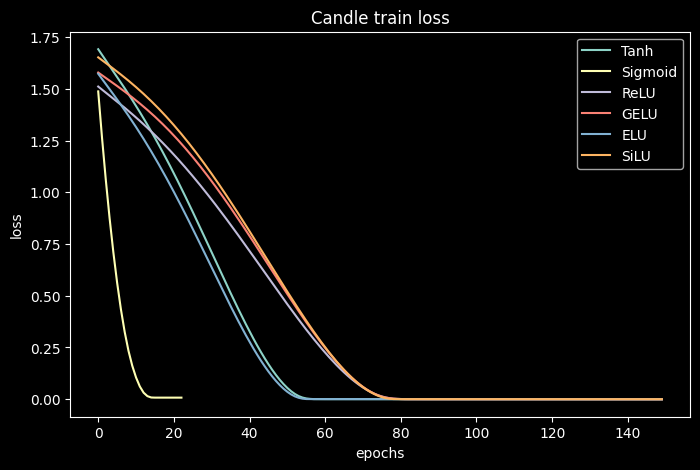

In [ ]:
# Plotting train losses
plt.figure(figsize=(8, 5))
for act, loss in history_train.items():
    plt.plot(loss, label=act)
plt.title('Candle train loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

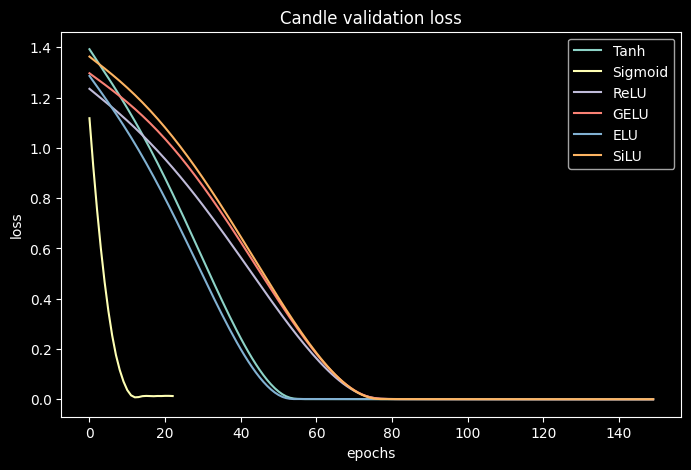

In [ ]:
# Plotting validation loss
plt.figure(figsize=(8, 5))
for act, loss in history_val.items():
    plt.plot(loss, label=act)
plt.title('Candle validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

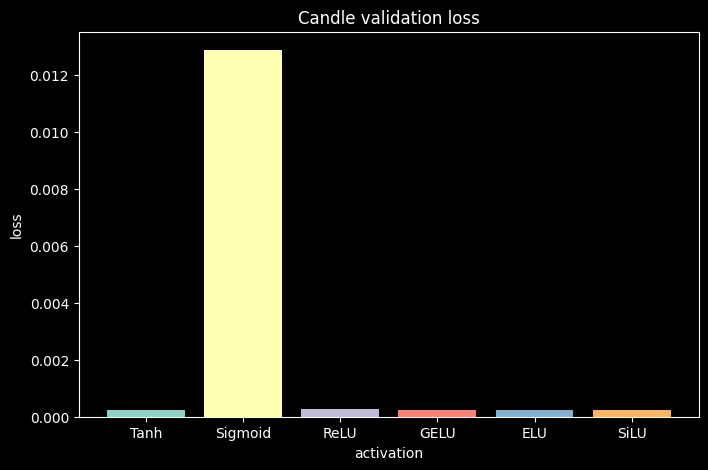

In [ ]:
# Plotting test loss
plt.figure(figsize=(8, 5))
for act, loss in test_losses.items():
    plt.bar(act, loss)
plt.title('Candle validation loss')
plt.ylabel('loss')
plt.xlabel('activation')
# plt.legend(loc='best')
plt.show()

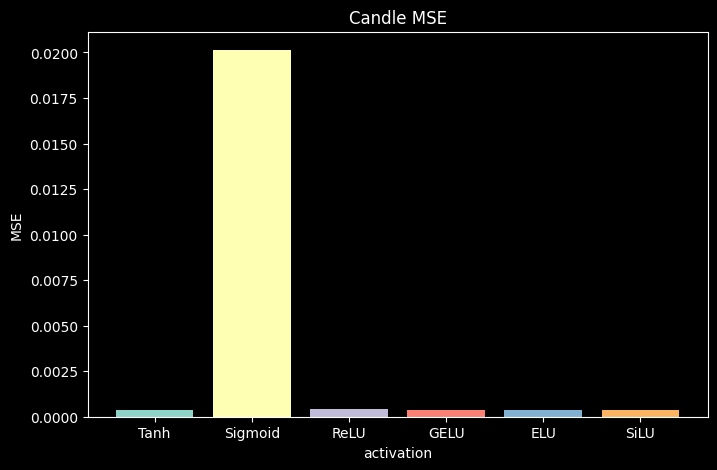

In [ ]:
# Plotting test mse
plt.figure(figsize=(8, 5))
for act, mse in test_mses.items():
    plt.bar(act, mse)
plt.title('Candle MSE')
plt.ylabel('MSE')
plt.xlabel('activation')
# plt.legend(loc='best')
plt.show()

In [ ]:
'''# Plotting actual vs. predicted prices
def plot_predictions(model, data_loader, name):
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            plt.plot(outputs[..., mapp[name]], label=f'Predicted {name} price')
            plt.plot(targets[..., mapp[name]].numpy(), label=f'Actual {name} price')
            break  # Plot only the first batch
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.title(f'EUR/USD {name} price')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

mapp = {"Open": 0, "High": 1, "Low": 2, "Close": 3}
for name in ["Open", "High", "Low", "Close"]:
    plot_predictions(models['ReLU'], test_loader, name)
'''
print("Nevermind")

Nevermind


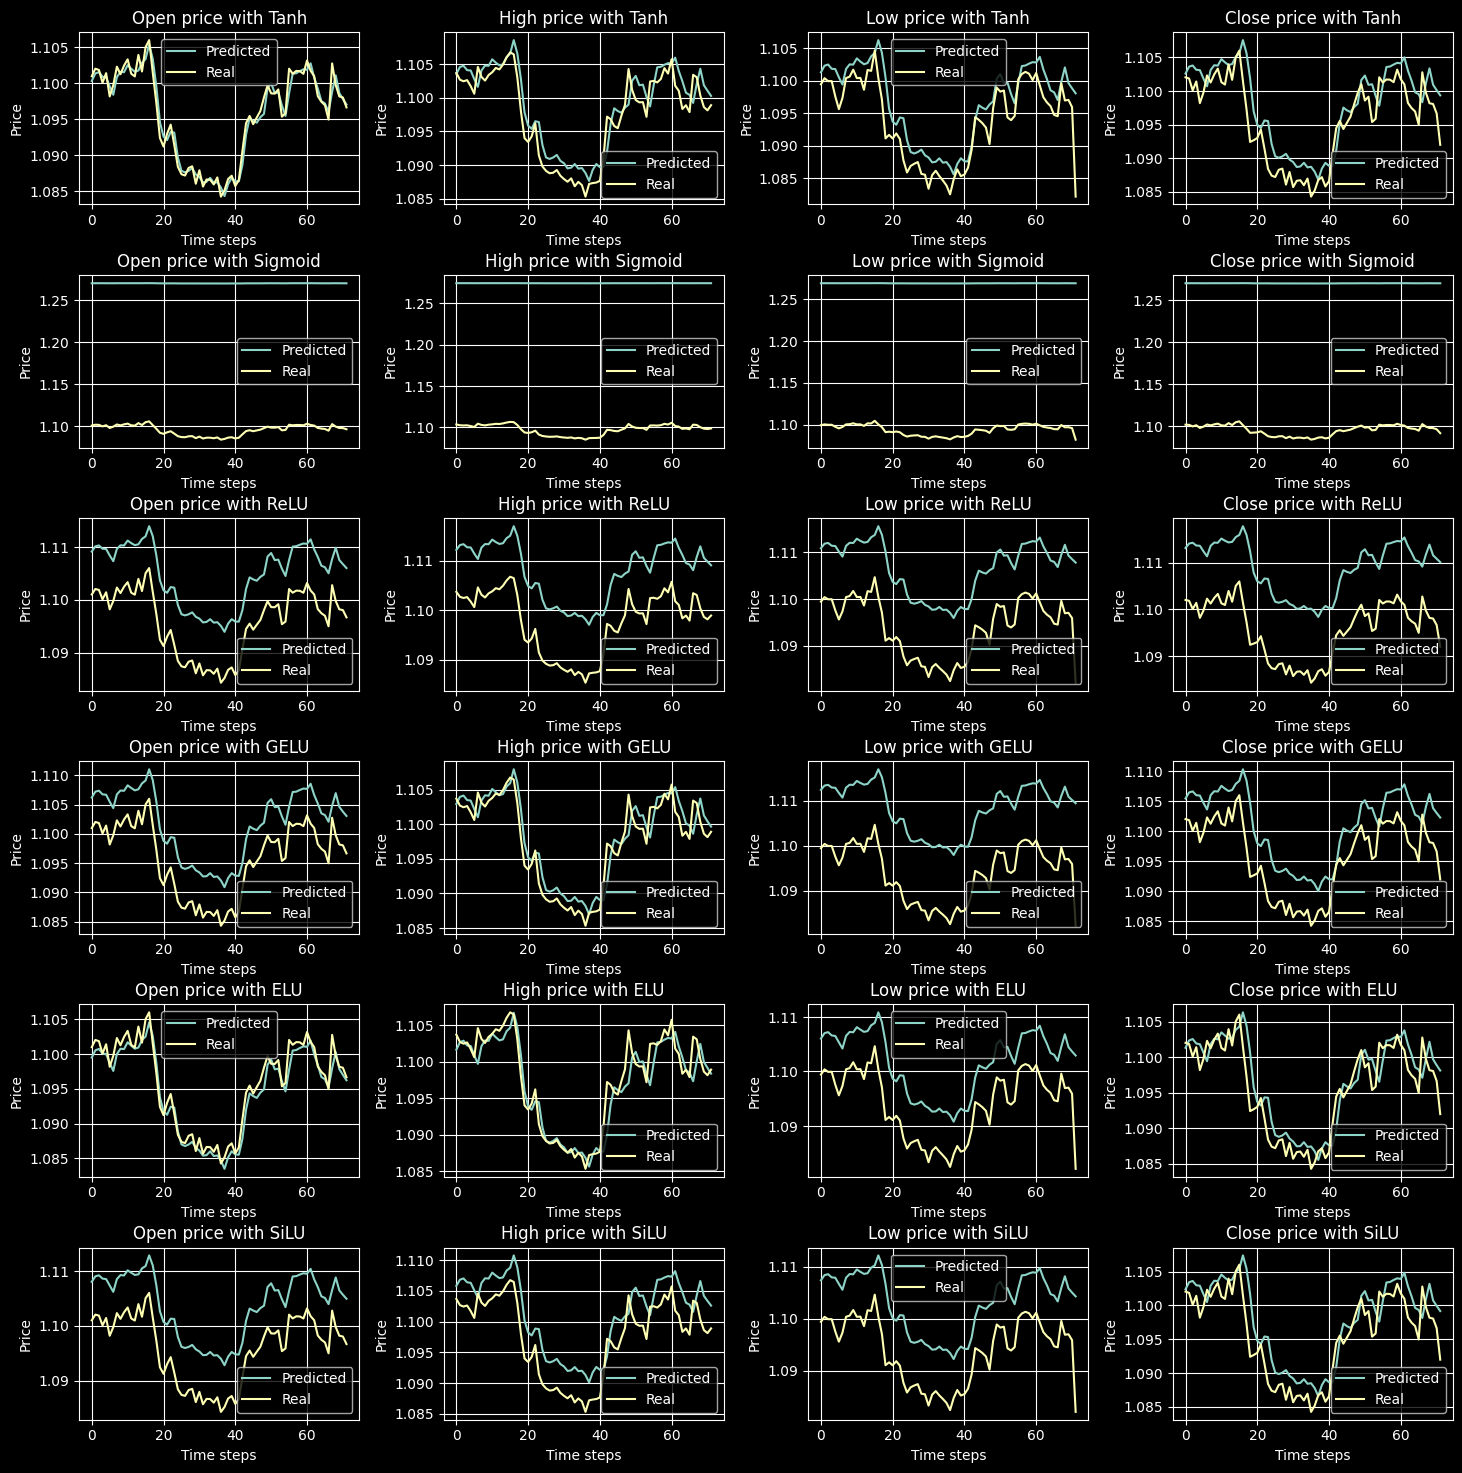

In [ ]:
# Plotting actual vs. predicted prices with subplots and multiple activation functions
def plot_predictions(model: nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     name: str,
                     activation: str):
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            # apply the activation function to the outputs
            outputs = torch.tensor(outputs).numpy()
            # plot the outputs and targets on the subplot
            ax.plot(outputs[..., mapp[name]], label=f'Predicted')
            ax.plot(targets[..., mapp[name]].numpy(), label=f'Real')
            break  # Plot only the first batch
    # set the subplot title, labels, and legend
    ax.set_title(f'{name} price with {activation}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Price')
    ax.legend(loc='best')
    ax.grid(True)

mapp = {"Open": 0, "High": 1, "Low": 2, "Close": 3}
# Create a figure and a grid of subplots with 5 rows and 4 columns
fig, axes = plt.subplots(len(activations), len(mapp), figsize=(15, 15))

# Adjust the spacing between the subplots
fig.tight_layout(pad=3.0)
# loop over the activation functions and the names
for i, activation in enumerate(activations):
    for j, name in enumerate(mapp.keys()):
        # get the subplot at row i and column j
        ax = axes[i, j]
        # plot the predictions on the subplot
        plot_predictions(models[activation], test_loader, name, activation)

# Show the figure
plt.show()

In [ ]:
'''# Plotting error
error_dict = {'relu': [history_val['ReLU'] for _ in range(4)]}  # Assuming relu activation for simplicity
plt.figure(figsize=(5, 4))
groups = ['Open', 'High', 'Low', 'Close']
barWidth = 0.12
r1 = np.arange(1)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
for i, (name, errors) in enumerate(error_dict.items()):
    plt.bar(r1 if i == 0 else r2 if i == 1 else r3 if i == 2 else r4, errors, color=plt.cm.jet(i / len(error_dict)), width=barWidth, edgecolor='white', label=name)
plt.xlabel('Activation function', fontweight='bold')
plt.ylabel('Mean Square Error', fontweight='bold')
plt.xticks([r + barWidth for r in range(1)], groups)
plt.legend(loc="best")
plt.show()'''
print("Nevermind")

Nevermind


In [ ]:
# Saving predictions
def save_predictions(model: nn.Module, data_loader: torch.utils.data.DataLoader, name: str):
    model.eval()
    with torch.no_grad():
        outputs = []
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            preds = model(inputs).cpu().numpy()
            outputs.extend(preds)
    outputs = np.array(outputs)
    df = pd.DataFrame(outputs, columns=['Open', 'High', 'Low', 'Close'])
    df.to_csv(f'{base_dir}/FLF_results_{name}_activation.csv', index=False)

for act, model in models.items():
    save_predictions(model, test_loader, act)
    print(f"Done saving predictions for activation {act}.")

Done saving predictions for activation Tanh.
Done saving predictions for activation Sigmoid.
Done saving predictions for activation ReLU.
Done saving predictions for activation GELU.
Done saving predictions for activation ELU.
Done saving predictions for activation SiLU.
